<a href="https://colab.research.google.com/github/RitaROK/Analysis/blob/main/Estimation_of_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.unumpy as unp 
import scipy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, r_regression, SelectPercentile, mutual_info_regression, SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error, r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import RepeatedKFold

def get_color(n, basecolor):
  current_palette = sns.dark_palette(n_colors=n, color=basecolor)
  sns.palplot(current_palette)
  colors = np.zeros(n, dtype=object)
  for color in range(n):
    colors[color] = current_palette[color]
  return colors

In [16]:
#@title Load RoI data
roi = pd.read_csv('/content/drive/MyDrive/LIME/roi.csv')
roi['eta'] = roi['TSigma']*155 / roi['TAmp']

In [ ]:
#@title One Feature Fit Function

def probe_p(roi, feature, pol):
  Y = roi['z[cm]'].loc[roi['z[cm]']>0]
  X = roi[[feature]].loc[roi['z[cm]']>0]
  polynomial_features= PolynomialFeatures(degree=pol)
  X = polynomial_features.fit_transform(X)
  X2 = sm.add_constant(X)
  est = sm.OLS(Y, X2)
  est2 = est.fit()
  print(est2.summary())

def onefeat(roi, feature, xmin, xmax, pol):

  fig, (ax) = plt.subplots(1,2, figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k', gridspec_kw={'width_ratios': [2, 1]}) 

  # Background
  box = ax[0].boxplot(roi[feature].loc[roi['z[cm]']==0], positions=[0], widths=1, vert=0)
  plt.setp(box['whiskers'], color='k')
  plt.setp(box['fliers'], markeredgecolor='k')
  plt.setp(box['boxes'], color='k')
  plt.setp(box['caps'], color='k')
  plt.setp(box['medians'], color='k')

  violin = ax[0].violinplot(roi[feature].loc[roi['z[cm]']==0], positions=[0], widths=3, showextrema=False, vert=0)
  plt.setp(violin['bodies'], color='darkgray', alpha=1)

  # Source Data
  data = []
  for d in [5,10,15,20,25,30,35,40,45]:
      data.append(np.array(roi[feature].loc[roi['z[cm]']==d]))

  box = ax[0].boxplot(data, positions=[5,10,15,20,25,30,35,40,45], widths=1, vert=0)
  plt.setp(box['whiskers'], color='k')
  plt.setp(box['fliers'], markeredgecolor='k')
  plt.setp(box['boxes'], color='k')
  plt.setp(box['caps'], color='k')
  plt.setp(box['medians'], color='k')
  violin = ax[0].violinplot(data, positions=[5,10,15,20,25,30,35,40,45], widths=3, showextrema=False, vert=0)
  plt.setp(violin['bodies'], color='tab:orange', alpha=1)

  # Plot Settings
  ax[0].set_ylim(-2.5,50)

  ax[0].set_xlim(xmin, xmax)
  ax[0].spines["right"].set_visible(False)
  ax[0].spines["top"].set_visible(False)
  ax[0].set_xlabel(feature, y=0.5, ha='center', fontsize=22)
  ax[0].tick_params(axis='both', which='both', labelsize=22)
  ax[0].set_ylabel('Interaction Depth, $z$ [cm]', x=0.5, ha='center', fontsize=22)

  # Linear fit
  Y = roi['z[cm]'].loc[roi['z[cm]']>0]
  X = roi[[feature]].loc[roi['z[cm]']>0]

  results = np.ones((4+pol,500))*np.nan
  i = 0
  rkf = RepeatedKFold(n_splits=10, n_repeats=50, random_state=0)
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    polynomial_features= PolynomialFeatures(degree=pol)
    X_train = polynomial_features.fit_transform(X_train)
    X_test = polynomial_features.fit_transform(X_test)
    X_test = sm.add_constant(X_test)

    clf = LinearRegression().fit(X_train, y_train)
    preds = clf.predict(X_test)

    #Residual plot
    residuals = y_test-preds
    ax[1].hist(residuals, bins=50, color='tab:orange', alpha=0.3, histtype='step')

    results[0,i] = r2_score(y_test, preds) # r2
    results[1,i] = np.sqrt(mean_squared_error(y_test, preds)) # RMSE
    results[2,i] = mean_absolute_error(y_test, preds) # MAE
    results[3,i]=clf.intercept_ # intercept
    for coefficient in range(0,pol):
      results[4+coefficient, i] = clf.coef_[coefficient+1]

    i=i+1

  # Settings of residual plot
  ax[1].axvline(x=0, color='k', ls='--', lw=1.5)
  ax[1].spines["right"].set_visible(False)
  ax[1].spines["top"].set_visible(False)
  ax[1].set_xlabel('Residuals [cm]', y=0.5, ha='center', fontsize=22)
  ax[1].tick_params(axis='both', which='both', labelsize=22)
  ax[1].set_ylabel('Counts [-]', x=0.5, ha='center', fontsize=22)
  ax[1].set_xlim(-30,30)

  print('MODEL SUMMARY:')
  print('r2 = ', ufloat(np.mean(results[0,:]), 3*np.std(results[0,:])))
  print('RMSE = ', ufloat(np.mean(results[1,:]), 3*np.std(results[1,:])))
  print('MAE = ', ufloat(np.mean(results[2,:]), 3*np.std(results[2,:])))
  intercept = np.mean(results[3,:])
  dintercept = 3*np.std(results[3,:])
  print('Intercept: ', ufloat(np.mean(results[3,:]), 3*np.std(results[3,:])))
  coef = []
  dcoef = []
  for coefficient in range(0,pol):
    coef.append(np.mean(results[4+coefficient,:]))
    dcoef.append(3*np.std(results[4+coefficient,:]))
    print(coefficient+1,'orded coef. = ', ufloat(np.mean(results[4+coefficient,:]), 3*np.std(results[4+coefficient,:])))
  x_plot = np.arange (xmin, xmax, 0.1)
  y = intercept
  y_up = intercept+dintercept
  y_down = intercept-dintercept
  #y_down = 
  for c in range(1,len(coef)+1):
    y = y + x_plot**c * coef[c-1]
    y_up = y_up + x_plot**c * (coef[c-1]+dcoef[c-1])
    y_down = y_down + x_plot**c * (coef[c-1]-dcoef[c-1])

  ax[0].plot(x_plot, y, color='tab:blue')
  ax[0].fill_between(x_plot, y_down, y_up, color='tab:blue', alpha=0.4, zorder=4)
  plt.show()

# Transverse Profile, $\eta$

In [ ]:
#@markdown Linear models with $\eta$ are only significant up to order 4.
probe_p(roi, 'eta', 5)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                 1.940e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:02:09   Log-Likelihood:            -9.4486e+05
No. Observations:              250677   AIC:                         1.890e+06
Df Residuals:                  250671   BIC:                         1.890e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.9412      0.752    -67.754      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.170+/-0.016
RMSE =  11.25+/-0.14
MAE =  9.36+/-0.11
Intercept:  6.92+/-0.14
1 orded coef. =  25.57+/-0.21


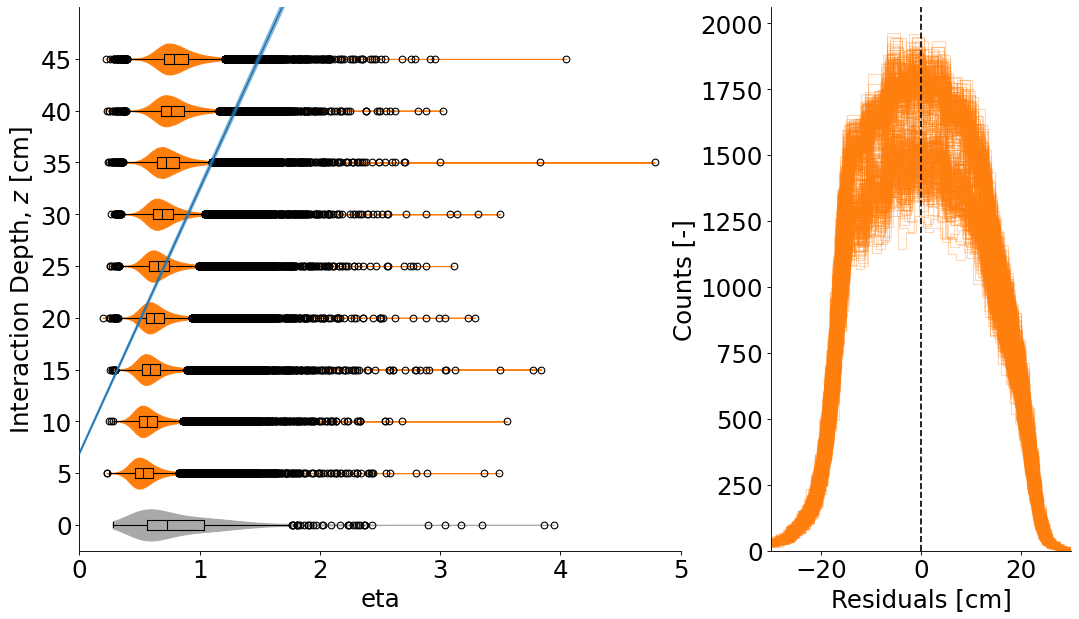

In [ ]:
## Simple linear regression

feature = 'eta' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 0 #@param {type:"number"}
xmax = 5 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

# Feature Engineering

In [ ]:
Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
X = roi.drop(['z[cm]', 'Id'], axis=1).loc[roi['z[cm]']>=4]

## Irrelevant and higly-correlated features

In [ ]:
#@title Removal of energy-dependent features
energy_dep_feat = ['Integral', 'CorrIntegral', 'TAmp', 'Size', 'Hits', 'Width', 'Length']
X=X.drop(energy_dep_feat, axis=1)
X.columns

Index(['Slim', 'PathLen', 'xMax', 'xMin', 'yMax', 'yMin', 'yMean', 'xMean',
       'TChi2', 'TSigma', 'TStatus', 'TFWHM', 'Theta', 'TMean', 'TRMS', 'RMS',
       'Pearson', 'LStatus', 'Energy', 'Short_RMS', 'LChi2', 'LRMS', 'LAmp',
       'LMean', 'LSigma', 'Long_RMS', 'MAmp', 'MFWHM', 'MMean', 'MProm',
       'Pixel', 'eta'],
      dtype='object')

In [ ]:
#@title Removal of constant and quasi-constant features
#@markdown The cluster Slimness, Pathlength, TStatus, LStatus, Person coefficient and Energy do not provide any information to the dataset.

#@markdown They will be removed from further analysis.
constant = []
print('Constant Features and how many times they were selected:')
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = VarianceThreshold( threshold=0.01)
  sel.fit(X_train) 
  for feature in [x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]:
    constant.append(feature)
for feature in set(constant):
  print(feature, constant.count(feature))
X=X.drop(set(constant), axis=1)
print('Selected columns:', X.columns)

Constant Features and how many times they were selected:
Energy 100
PathLen 100
LStatus 100
Slim 100
Pearson 100
TStatus 100
Selected columns: Index(['xMax', 'xMin', 'yMax', 'yMin', 'yMean', 'xMean', 'TChi2', 'TSigma',
       'TFWHM', 'Theta', 'TMean', 'TRMS', 'RMS', 'Short_RMS', 'LChi2', 'LRMS',
       'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp', 'MFWHM', 'MMean',
       'MProm', 'Pixel', 'eta'],
      dtype='object')


In [ ]:
# Short RMS and LRMS are the same, so I only keep LRMS
np.sum((roi['Short_RMS']-roi['LRMS'])**2)
#np.sum((roi['Long_RMS']-roi['TRMS'])**2)

0.0

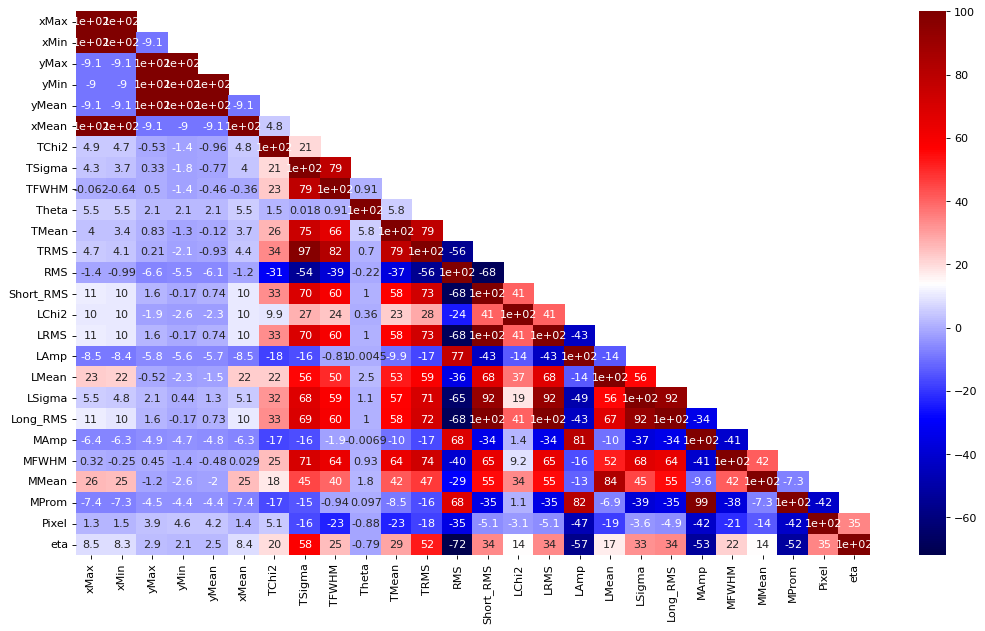

xMax and ['xMin' 'xMean']
xMin and ['xMax' 'xMean']
yMax and ['yMin' 'yMean']
yMin and ['yMax' 'yMean']
yMean and ['yMax' 'yMin']
xMean and ['xMax' 'xMin']
TSigma and ['TRMS']
TRMS and ['TSigma']
Short_RMS and ['LRMS' 'LSigma' 'Long_RMS']
LRMS and ['Short_RMS' 'LSigma' 'Long_RMS']
LSigma and ['Short_RMS' 'LRMS' 'Long_RMS']
Long_RMS and ['Short_RMS' 'LRMS' 'LSigma']
MAmp and ['MProm']
MProm and ['MAmp']


In [ ]:
#@title Correlation Coefficients
corr = X.corr()
upper = corr.where(np.tril(np.ones(corr.shape), k=1).astype(bool))
fig, (ax) = plt.subplots(figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 
sns.heatmap(upper*100, annot=True, cmap='seismic')
plt.show()

to_drop = [column for column in corr.columns if any(np.abs(corr[column]) >= 0.9)]
for feature in to_drop:
  corr_feat = np.asarray(corr.loc[(corr[feature] >= 0.85)].index)
  if len(corr_feat) > 1:
    print(feature, 'and', corr_feat[corr_feat!=feature])

#X=X.drop(['xMax', 'xMin', 'yMax', 'yMin', 'MProm', 'Short_RMS', 'Long_RMS', 'LRMS', 'Integral', 'Hits', 'Size', 'TRMS', 'TAmp', 'Length', 'Width', 'TMean'], axis=1)
#print('Remaining columns', X.columns)

## Statistical tests

In [ ]:
#@title Load good features

Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
X = roi.drop(['z[cm]', 'Id', # of course not
              'Integral', 'CorrIntegral', 'TAmp', 'Size', 'Hits', 'Length', 'Width', # Energy-dependent
              'TStatus', 'Pearson', 'LStatus', 'PathLen', 'Slim', 'Energy', # Low variance 
              'Short_RMS', 'xMin', 'xMax', 'yMin', 'yMax' # rendundant
              ], axis=1).loc[roi['z[cm]']>=4]
X.columns

Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta'],
      dtype='object')

In [ ]:
#@title Select 5 Best using F_regression
#@markdown I selected 5 features
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
p = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(f_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
  p = np.append(p, sel.pvalues_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'F-Score': scores,
        'P-value': p}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t f-score :', ufloat(df['F-Score'].loc[df['Feature']==feature].mean(), df['F-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['F-Score'].loc[df['Feature']==feature].count(),
          '\n \t p-value :', ufloat(df['P-value'].loc[df['Feature']==feature].mean(), df['P-value'].loc[df['Feature']==feature].std()))
  display('-'*100)

TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title Select 5 Best using r_regression
#@markdown I selected 5 features
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(r_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'R-Score': scores}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t r-score :', ufloat(df['R-Score'].loc[df['Feature']==feature].mean(), df['R-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['R-Score'].loc[df['Feature']==feature].count())
  display('-'*100)

TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title Select 5 Best using mutual_info_regression
#@markdown I selected 5 features

rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(mutual_info_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'Info-Score': scores}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t score :', ufloat(df['Info-Score'].loc[df['Feature']==feature].mean(), df['Info-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['Info-Score'].loc[df['Feature']==feature].count())
  display('-'*100)

TSigma 
 	 score : 0.4870+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 score : 0.5136+/-0.0007 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 score : 0.3873+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 score : 0.3882+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 score : 0.3864+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

## 2nd order interactions

In [4]:
#@title Load good features

Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
X = roi.drop(['z[cm]', 'Id', # of course not
              'Integral', 'CorrIntegral', 'TAmp', 'Size', 'Hits', 'Length', 'Width', # Energy-dependent
              'TStatus', 'Pearson', 'LStatus', 'PathLen', 'Slim', 'Energy', # Low variance 
              'Short_RMS', 'xMin', 'xMax', 'yMin', 'yMax' # rendundant
              ], axis=1).loc[roi['z[cm]']>=4]
X.columns

Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta'],
      dtype='object')

In [5]:
#@title Initialization and interaction function

def interaction(X, Y, feature):
  original_len = len(X.columns)

  for feat in X.drop(feature, axis=1).columns[:original_len]:
    if (np.asarray(X[feat]).all() != 0):
      X[feature+'*'+feat] = X[feature]*X[feat]
      X[feature+'/'+feat] = X[feature]/X[feat]
    else:
      print(feat)
  print(X.columns)

  print('F-regression')
  rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

  selected = np.asarray([])
  scores = np.asarray([])
  p = np.asarray([])
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sel = SelectKBest(f_regression, k=5)
    sel.fit(X_train, y_train)
    selected = np.append(selected, sel.get_feature_names_out())
    scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
    p = np.append(p, sel.pvalues_[sel.get_support(indices=True)])
  data = {'Feature': selected,
        'F-Score': scores,
        'P-value': p}
  df = pd.DataFrame(data)

  for feature in df['Feature'].unique():
    print(feature, '\n \t f-score :', ufloat(df['F-Score'].loc[df['Feature']==feature].mean(), df['F-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['F-Score'].loc[df['Feature']==feature].count(),
          '\n \t p-value :', ufloat(df['P-value'].loc[df['Feature']==feature].mean(), df['P-value'].loc[df['Feature']==feature].std()))
    display('-'*100)

  print('R-regression')

  selected = np.asarray([])
  scores = np.asarray([])
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sel = SelectKBest(r_regression, k=5)
    sel.fit(X_train, y_train)
    selected = np.append(selected, sel.get_feature_names_out())
    scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
  data = {'Feature': selected,
        'R-Score': scores}
  df = pd.DataFrame(data)

  for feature in df['Feature'].unique():
    print(feature, '\n \t r-score :', ufloat(df['R-Score'].loc[df['Feature']==feature].mean(), df['R-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['R-Score'].loc[df['Feature']==feature].count())
    display('-'*100)

  # Run only for sigma_T and sigma_L (takes a lot of time)
  print('Mutual Information')
  selected = np.asarray([])
  scores = np.asarray([])
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sel = SelectKBest(mutual_info_regression, k=5)
    sel.fit(X_train, y_train)
    selected = np.append(selected, sel.get_feature_names_out())
    scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
  data = {'Feature': selected,
        'Info-Score': scores}
  df = pd.DataFrame(data)

  for feature in df['Feature'].unique():
    print(feature, '\n \t score :', ufloat(df['Info-Score'].loc[df['Feature']==feature].mean(), df['Info-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['Info-Score'].loc[df['Feature']==feature].count())
    display('-'*100)


In [ ]:
#@title $\sigma_T$
interaction(X, Y, 'TSigma')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'TSigma*yMean',
       'TSigma/yMean', 'TSigma*xMean', 'TSigma/xMean', 'TSigma*TChi2',
       'TSigma/TChi2', 'TSigma*TFWHM', 'TSigma/TFWHM', 'TSigma*TMean',
       'TSigma/TMean', 'TSigma*TRMS', 'TSigma/TRMS', 'TSigma*RMS',
       'TSigma/RMS', 'TSigma*LChi2', 'TSigma/LChi2', 'TSigma*LRMS',
       'TSigma/LRMS', 'TSigma*LAmp', 'TSigma/LAmp', 'TSigma*LMean',
       'TSigma/LMean', 'TSigma*LSigma', 'TSigma/LSigma', 'TSigma*Long_RMS',
       'TSigma/Long_RMS', 'TSigma*MAmp', 'TSigma/MAmp', 'TSigma*MFWHM',
       'TSigma/MFWHM', 'TSigma*MMean', 'TSigma/MMean', 'TSigma*MProm',
       'TSigma/MProm', 'TSigma*eta', 'TSigma/eta'],
      dtype='object')
F-regression
TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TSigma*TRMS 
 	 f-score : (3.226+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TSigma*LRMS 
 	 f-score : (3.945+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TSigma*LSigma 
 	 f-score : (3.983+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TSigma*Long_RMS 
 	 f-score : (3.930+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*TRMS 
 	 r-score : 0.76710+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*LRMS 
 	 r-score : 0.79762+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*LSigma 
 	 r-score : 0.79900+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*Long_RMS 
 	 r-score : 0.79704+/-0.00032 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Mutual Information
TRMS 
 	 score : 0.5136+/-0.0007 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*TRMS 
 	 score : 0.5106+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*LRMS 
 	 score : 0.5582+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*LSigma 
 	 score : 0.5630+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*Long_RMS 
 	 score : 0.5559+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $\sigma_L$
interaction(X, Y, 'LSigma')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'LSigma*yMean',
       'LSigma/yMean', 'LSigma*xMean', 'LSigma/xMean', 'LSigma*TChi2',
       'LSigma/TChi2', 'LSigma*TSigma', 'LSigma/TSigma', 'LSigma*TFWHM',
       'LSigma/TFWHM', 'LSigma*TMean', 'LSigma/TMean', 'LSigma*TRMS',
       'LSigma/TRMS', 'LSigma*RMS', 'LSigma/RMS', 'LSigma*LChi2',
       'LSigma/LChi2', 'LSigma*LRMS', 'LSigma/LRMS', 'LSigma*LAmp',
       'LSigma/LAmp', 'LSigma*LMean', 'LSigma/LMean', 'LSigma*Long_RMS',
       'LSigma/Long_RMS', 'LSigma*MAmp', 'LSigma/MAmp', 'LSigma*MFWHM',
       'LSigma/MFWHM', 'LSigma*MMean', 'LSigma/MMean', 'LSigma*MProm',
       'LSigma/MProm', 'LSigma*eta', 'LSigma/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma*TSigma 
 	 f-score : (3.983+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma*TFWHM 
 	 f-score : (3.091+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma*TRMS 
 	 f-score : (4.132+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TSigma 
 	 r-score : 0.79900+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TFWHM 
 	 r-score : 0.76032+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TRMS 
 	 r-score : 0.80425+/-0.00030 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Mutual Information
TSigma 
 	 score : 0.4870+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 score : 0.5136+/-0.0007 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TSigma 
 	 score : 0.5630+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TFWHM 
 	 score : 0.4882+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TRMS 
 	 score : 0.5681+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $y_{\text{mean}}$
interaction(X, Y, 'yMean')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'yMean*xMean', 'yMean/xMean',
       'yMean*TChi2', 'yMean/TChi2', 'yMean*TSigma', 'yMean/TSigma',
       'yMean*TFWHM', 'yMean/TFWHM', 'yMean*TMean', 'yMean/TMean',
       'yMean*TRMS', 'yMean/TRMS', 'yMean*RMS', 'yMean/RMS', 'yMean*LChi2',
       'yMean/LChi2', 'yMean*LRMS', 'yMean/LRMS', 'yMean*LAmp', 'yMean/LAmp',
       'yMean*LMean', 'yMean/LMean', 'yMean*LSigma', 'yMean/LSigma',
       'yMean*Long_RMS', 'yMean/Long_RMS', 'yMean*MAmp', 'yMean/MAmp',
       'yMean*MFWHM', 'yMean/MFWHM', 'yMean*MMean', 'yMean/MMean',
       'yMean*MProm', 'yMean/MProm', 'yMean*eta', 'yMean/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $x_{\text{mean}}$
interaction(X, Y, 'xMean')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'xMean*yMean', 'xMean/yMean',
       'xMean*TChi2', 'xMean/TChi2', 'xMean*TSigma', 'xMean/TSigma',
       'xMean*TFWHM', 'xMean/TFWHM', 'xMean*TMean', 'xMean/TMean',
       'xMean*TRMS', 'xMean/TRMS', 'xMean*RMS', 'xMean/RMS', 'xMean*LChi2',
       'xMean/LChi2', 'xMean*LRMS', 'xMean/LRMS', 'xMean*LAmp', 'xMean/LAmp',
       'xMean*LMean', 'xMean/LMean', 'xMean*LSigma', 'xMean/LSigma',
       'xMean*Long_RMS', 'xMean/Long_RMS', 'xMean*MAmp', 'xMean/MAmp',
       'xMean*MFWHM', 'xMean/MFWHM', 'xMean*MMean', 'xMean/MMean',
       'xMean*MProm', 'xMean/MProm', 'xMean*eta', 'xMean/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title ${\chi_Tˆ2}$
interaction(X, Y, 'TChi2')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'TChi2*yMean', 'TChi2/yMean',
       'TChi2*xMean', 'TChi2/xMean', 'TChi2*TSigma', 'TChi2/TSigma',
       'TChi2*TFWHM', 'TChi2/TFWHM', 'TChi2*TMean', 'TChi2/TMean',
       'TChi2*TRMS', 'TChi2/TRMS', 'TChi2*RMS', 'TChi2/RMS', 'TChi2*LChi2',
       'TChi2/LChi2', 'TChi2*LRMS', 'TChi2/LRMS', 'TChi2*LAmp', 'TChi2/LAmp',
       'TChi2*LMean', 'TChi2/LMean', 'TChi2*LSigma', 'TChi2/LSigma',
       'TChi2*Long_RMS', 'TChi2/Long_RMS', 'TChi2*MAmp', 'TChi2/MAmp',
       'TChi2*MFWHM', 'TChi2/MFWHM', 'TChi2*MMean', 'TChi2/MMean',
       'TChi2*MProm', 'TChi2/MProm', 'TChi2*eta', 'TChi2/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title FWHM$_T$
interaction(X, Y, 'TFWHM')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'TFWHM*yMean', 'TFWHM/yMean',
       'TFWHM*xMean', 'TFWHM/xMean', 'TFWHM*TChi2', 'TFWHM/TChi2',
       'TFWHM*TSigma', 'TFWHM/TSigma', 'TFWHM*TMean', 'TFWHM/TMean',
       'TFWHM*TRMS', 'TFWHM/TRMS', 'TFWHM*RMS', 'TFWHM/RMS', 'TFWHM*LChi2',
       'TFWHM/LChi2', 'TFWHM*LRMS', 'TFWHM/LRMS', 'TFWHM*LAmp', 'TFWHM/LAmp',
       'TFWHM*LMean', 'TFWHM/LMean', 'TFWHM*LSigma', 'TFWHM/LSigma',
       'TFWHM*Long_RMS', 'TFWHM/Long_RMS', 'TFWHM*MAmp', 'TFWHM/MAmp',
       'TFWHM*MFWHM', 'TFWHM/MFWHM', 'TFWHM*MMean', 'TFWHM/MMean',
       'TFWHM*MProm', 'TFWHM/MProm', 'TFWHM*eta', 'TFWHM/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM*LRMS 
 	 f-score : (3.004+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM*LSigma 
 	 f-score : (3.091+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM*Long_RMS 
 	 f-score : (2.995+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM*LRMS 
 	 r-score : 0.75572+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM*LSigma 
 	 r-score : 0.76032+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM*Long_RMS 
 	 r-score : 0.75521+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $\theta$
interaction(X, Y, 'Theta')

Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'Theta*yMean', 'Theta/yMean',
       'Theta*xMean', 'Theta/xMean', 'Theta*TChi2', 'Theta/TChi2',
       'Theta*TSigma', 'Theta/TSigma', 'Theta*TFWHM', 'Theta/TFWHM',
       'Theta*TMean', 'Theta/TMean', 'Theta*TRMS', 'Theta/TRMS', 'Theta*RMS',
       'Theta/RMS', 'Theta*LChi2', 'Theta/LChi2', 'Theta*LRMS', 'Theta/LRMS',
       'Theta*LAmp', 'Theta/LAmp', 'Theta*LMean', 'Theta/LMean',
       'Theta*LSigma', 'Theta/LSigma', 'Theta*Long_RMS', 'Theta/Long_RMS',
       'Theta*MAmp', 'Theta/MAmp', 'Theta*MFWHM', 'Theta/MFWHM', 'Theta*MMean',
       'Theta/MMean', 'Theta*MProm', 'Theta/MProm', 'Theta*eta', 'Theta/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title TMean
interaction(X, Y, 'TMean')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'TMean*yMean', 'TMean/yMean',
       'TMean*xMean', 'TMean/xMean', 'TMean*TChi2', 'TMean/TChi2',
       'TMean*TSigma', 'TMean/TSigma', 'TMean*TFWHM', 'TMean/TFWHM',
       'TMean*TRMS', 'TMean/TRMS', 'TMean*RMS', 'TMean/RMS', 'TMean*LChi2',
       'TMean/LChi2', 'TMean*LRMS', 'TMean/LRMS', 'TMean*LAmp', 'TMean/LAmp',
       'TMean*LMean', 'TMean/LMean', 'TMean*LSigma', 'TMean/LSigma',
       'TMean*Long_RMS', 'TMean/Long_RMS', 'TMean*MAmp', 'TMean/MAmp',
       'TMean*MFWHM', 'TMean/MFWHM', 'TMean*MMean', 'TMean/MMean',
       'TMean*MProm', 'TMean/MProm', 'TMean*eta', 'TMean/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TMean*LRMS 
 	 f-score : (2.588+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TMean*LSigma 
 	 f-score : (2.676+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TMean*Long_RMS 
 	 f-score : (2.578+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TMean*LRMS 
 	 r-score : 0.73094+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TMean*LSigma 
 	 r-score : 0.73662+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TMean*Long_RMS 
 	 r-score : 0.73030+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [6]:
#@title TRMS
interaction(X, Y, 'TRMS')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'TRMS*yMean', 'TRMS/yMean',
       'TRMS*xMean', 'TRMS/xMean', 'TRMS*TChi2', 'TRMS/TChi2', 'TRMS*TSigma',
       'TRMS/TSigma', 'TRMS*TFWHM', 'TRMS/TFWHM', 'TRMS*TMean', 'TRMS/TMean',
       'TRMS*RMS', 'TRMS/RMS', 'TRMS*LChi2', 'TRMS/LChi2', 'TRMS*LRMS',
       'TRMS/LRMS', 'TRMS*LAmp', 'TRMS/LAmp', 'TRMS*LMean', 'TRMS/LMean',
       'TRMS*LSigma', 'TRMS/LSigma', 'TRMS*Long_RMS', 'TRMS/Long_RMS',
       'TRMS*MAmp', 'TRMS/MAmp', 'TRMS*MFWHM', 'TRMS/MFWHM', 'TRMS*MMean',
       'TRMS/MMean', 'TRMS*MProm', 'TRMS/MProm', 'TRMS*eta', 'TRMS/eta'],
      dtype='object')
F-regression
TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS/RMS 
 	 f-score : (3.365+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS*LRMS 
 	 f-score : (4.094+/-0.008)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS*LSigma 
 	 f-score : (4.132+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS*Long_RMS 
 	 f-score : (4.078+/-0.008)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS/RMS 
 	 r-score : 0.77372+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS*LRMS 
 	 r-score : 0.80294+/-0.00029 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS*LSigma 
 	 r-score : 0.80425+/-0.00030 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS*Long_RMS 
 	 r-score : 0.80239+/-0.00029 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Mutual Information
TRMS 
 	 score : 0.5136+/-0.0007 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS*TSigma 
 	 score : 0.5106+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS*LRMS 
 	 score : 0.5618+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS*LSigma 
 	 score : 0.5681+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS*Long_RMS 
 	 score : 0.5643+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title RMS
interaction(X, Y, 'RMS')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'RMS*yMean', 'RMS/yMean',
       'RMS*xMean', 'RMS/xMean', 'RMS*TChi2', 'RMS/TChi2', 'RMS*TSigma',
       'RMS/TSigma', 'RMS*TFWHM', 'RMS/TFWHM', 'RMS*TMean', 'RMS/TMean',
       'RMS*TRMS', 'RMS/TRMS', 'RMS*LChi2', 'RMS/LChi2', 'RMS*LRMS',
       'RMS/LRMS', 'RMS*LAmp', 'RMS/LAmp', 'RMS*LMean', 'RMS/LMean',
       'RMS*LSigma', 'RMS/LSigma', 'RMS*Long_RMS', 'RMS/Long_RMS', 'RMS*MAmp',
       'RMS/MAmp', 'RMS*MFWHM', 'RMS/MFWHM', 'RMS*MMean', 'RMS/MMean',
       'RMS*MProm', 'RMS/MProm', 'RMS*eta', 'RMS/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS/TSigma 
 	 f-score : (2.666+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS/TRMS 
 	 f-score : (2.832+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title LChi2
interaction(X, Y, 'LChi2')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'LChi2*yMean', 'LChi2/yMean',
       'LChi2*xMean', 'LChi2/xMean', 'LChi2*TChi2', 'LChi2/TChi2',
       'LChi2*TSigma', 'LChi2/TSigma', 'LChi2*TFWHM', 'LChi2/TFWHM',
       'LChi2*TMean', 'LChi2/TMean', 'LChi2*TRMS', 'LChi2/TRMS', 'LChi2*RMS',
       'LChi2/RMS', 'LChi2*LRMS', 'LChi2/LRMS', 'LChi2*LAmp', 'LChi2/LAmp',
       'LChi2*LMean', 'LChi2/LMean', 'LChi2*LSigma', 'LChi2/LSigma',
       'LChi2*Long_RMS', 'LChi2/Long_RMS', 'LChi2*MAmp', 'LChi2/MAmp',
       'LChi2*MFWHM', 'LChi2/MFWHM', 'LChi2*MMean', 'LChi2/MMean',
       'LChi2*MProm', 'LChi2/MProm', 'LChi2*eta', 'LChi2/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title LRMS
interaction(X, Y, 'LRMS')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'LRMS*yMean', 'LRMS/yMean',
       'LRMS*xMean', 'LRMS/xMean', 'LRMS*TChi2', 'LRMS/TChi2', 'LRMS*TSigma',
       'LRMS/TSigma', 'LRMS*TFWHM', 'LRMS/TFWHM', 'LRMS*TMean', 'LRMS/TMean',
       'LRMS*TRMS', 'LRMS/TRMS', 'LRMS*RMS', 'LRMS/RMS', 'LRMS*LChi2',
       'LRMS/LChi2', 'LRMS*LAmp', 'LRMS/LAmp', 'LRMS*LMean', 'LRMS/LMean',
       'LRMS*LSigma', 'LRMS/LSigma', 'LRMS*Long_RMS', 'LRMS/Long_RMS',
       'LRMS*MAmp', 'LRMS/MAmp', 'LRMS*MFWHM', 'LRMS/MFWHM', 'LRMS*MMean',
       'LRMS/MMean', 'LRMS*MProm', 'LRMS/MProm', 'LRMS*eta', 'LRMS/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS*TSigma 
 	 f-score : (3.945+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS*TFWHM 
 	 f-score : (3.004+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS*TRMS 
 	 f-score : (4.094+/-0.008)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS*TSigma 
 	 r-score : 0.79762+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS*TFWHM 
 	 r-score : 0.75572+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS*TRMS 
 	 r-score : 0.80294+/-0.00029 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title LAmp
interaction(X, Y, 'LAmp')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'LAmp*yMean', 'LAmp/yMean',
       'LAmp*xMean', 'LAmp/xMean', 'LAmp*TChi2', 'LAmp/TChi2', 'LAmp*TSigma',
       'LAmp/TSigma', 'LAmp*TFWHM', 'LAmp/TFWHM', 'LAmp*TMean', 'LAmp/TMean',
       'LAmp*TRMS', 'LAmp/TRMS', 'LAmp*RMS', 'LAmp/RMS', 'LAmp*LChi2',
       'LAmp/LChi2', 'LAmp*LRMS', 'LAmp/LRMS', 'LAmp*LMean', 'LAmp/LMean',
       'LAmp*LSigma', 'LAmp/LSigma', 'LAmp*Long_RMS', 'LAmp/Long_RMS',
       'LAmp*MAmp', 'LAmp/MAmp', 'LAmp*MFWHM', 'LAmp/MFWHM', 'LAmp*MMean',
       'LAmp/MMean', 'LAmp*MProm', 'LAmp/MProm', 'LAmp*eta', 'LAmp/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title LMean
interaction(X, Y, 'LMean')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'LMean*yMean', 'LMean/yMean',
       'LMean*xMean', 'LMean/xMean', 'LMean*TChi2', 'LMean/TChi2',
       'LMean*TSigma', 'LMean/TSigma', 'LMean*TFWHM', 'LMean/TFWHM',
       'LMean*TMean', 'LMean/TMean', 'LMean*TRMS', 'LMean/TRMS', 'LMean*RMS',
       'LMean/RMS', 'LMean*LChi2', 'LMean/LChi2', 'LMean*LRMS', 'LMean/LRMS',
       'LMean*LAmp', 'LMean/LAmp', 'LMean*LSigma', 'LMean/LSigma',
       'LMean*Long_RMS', 'LMean/Long_RMS', 'LMean*MAmp', 'LMean/MAmp',
       'LMean*MFWHM', 'LMean/MFWHM', 'LMean*MMean', 'LMean/MMean',
       'LMean*MProm', 'LMean/MProm', 'LMean*eta', 'LMean/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LMean*TRMS 
 	 f-score : (2.358+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean*TRMS 
 	 r-score : 0.7148+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title Long_RMS
interaction(X, Y, 'Long_RMS')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'Long_RMS*yMean',
       'Long_RMS/yMean', 'Long_RMS*xMean', 'Long_RMS/xMean', 'Long_RMS*TChi2',
       'Long_RMS/TChi2', 'Long_RMS*TSigma', 'Long_RMS/TSigma',
       'Long_RMS*TFWHM', 'Long_RMS/TFWHM', 'Long_RMS*TMean', 'Long_RMS/TMean',
       'Long_RMS*TRMS', 'Long_RMS/TRMS', 'Long_RMS*RMS', 'Long_RMS/RMS',
       'Long_RMS*LChi2', 'Long_RMS/LChi2', 'Long_RMS*LRMS', 'Long_RMS/LRMS',
       'Long_RMS*LAmp', 'Long_RMS/LAmp', 'Long_RMS*LMean', 'Long_RMS/LMean',
       'Long_RMS*LSigma', 'Long_RMS/LSigma', 'Long_RMS*MAmp', 'Long_RMS/MAmp',
       'Long_RMS*MFWHM', 'Long_RMS/MFWHM', 'Long_RMS*MMean', 'Long_RMS/MMean',
       'Long_RMS*MProm', 'Long_RMS/MProm', 'Long_RMS*eta', 'Long_RMS/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 #

'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS*TSigma 
 	 f-score : (3.930+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS*TFWHM 
 	 f-score : (2.995+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS*TRMS 
 	 f-score : (4.078+/-0.008)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS*TSigma 
 	 r-score : 0.79704+/-0.00032 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS*TFWHM 
 	 r-score : 0.75521+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS*TRMS 
 	 r-score : 0.80239+/-0.00029 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title MAmp
interaction(X, Y, 'MAmp')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'MAmp*yMean', 'MAmp/yMean',
       'MAmp*xMean', 'MAmp/xMean', 'MAmp*TChi2', 'MAmp/TChi2', 'MAmp*TSigma',
       'MAmp/TSigma', 'MAmp*TFWHM', 'MAmp/TFWHM', 'MAmp*TMean', 'MAmp/TMean',
       'MAmp*TRMS', 'MAmp/TRMS', 'MAmp*RMS', 'MAmp/RMS', 'MAmp*LChi2',
       'MAmp/LChi2', 'MAmp*LRMS', 'MAmp/LRMS', 'MAmp*LAmp', 'MAmp/LAmp',
       'MAmp*LMean', 'MAmp/LMean', 'MAmp*LSigma', 'MAmp/LSigma',
       'MAmp*Long_RMS', 'MAmp/Long_RMS', 'MAmp*MFWHM', 'MAmp/MFWHM',
       'MAmp*MMean', 'MAmp/MMean', 'MAmp*MProm', 'MAmp/MProm', 'MAmp*eta',
       'MAmp/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title MFWHM
interaction(X, Y, 'MFWHM')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'MFWHM*yMean', 'MFWHM/yMean',
       'MFWHM*xMean', 'MFWHM/xMean', 'MFWHM*TChi2', 'MFWHM/TChi2',
       'MFWHM*TSigma', 'MFWHM/TSigma', 'MFWHM*TFWHM', 'MFWHM/TFWHM',
       'MFWHM*TMean', 'MFWHM/TMean', 'MFWHM*TRMS', 'MFWHM/TRMS', 'MFWHM*RMS',
       'MFWHM/RMS', 'MFWHM*LChi2', 'MFWHM/LChi2', 'MFWHM*LRMS', 'MFWHM/LRMS',
       'MFWHM*LAmp', 'MFWHM/LAmp', 'MFWHM*LMean', 'MFWHM/LMean',
       'MFWHM*LSigma', 'MFWHM/LSigma', 'MFWHM*Long_RMS', 'MFWHM/Long_RMS',
       'MFWHM*MAmp', 'MFWHM/MAmp', 'MFWHM*MMean', 'MFWHM/MMean', 'MFWHM*MProm',
       'MFWHM/MProm', 'MFWHM*eta', 'MFWHM/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM*TSigma 
 	 f-score : (2.744+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM*TRMS 
 	 f-score : (2.767+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM*LRMS 
 	 f-score : (2.580+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM*TSigma 
 	 r-score : 0.7408+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM*TRMS 
 	 r-score : 0.7422+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM*LRMS 
 	 r-score : 0.7304+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title MMean
interaction(X, Y, 'MMean')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'MMean*yMean', 'MMean/yMean',
       'MMean*xMean', 'MMean/xMean', 'MMean*TChi2', 'MMean/TChi2',
       'MMean*TSigma', 'MMean/TSigma', 'MMean*TFWHM', 'MMean/TFWHM',
       'MMean*TMean', 'MMean/TMean', 'MMean*TRMS', 'MMean/TRMS', 'MMean*RMS',
       'MMean/RMS', 'MMean*LChi2', 'MMean/LChi2', 'MMean*LRMS', 'MMean/LRMS',
       'MMean*LAmp', 'MMean/LAmp', 'MMean*LMean', 'MMean/LMean',
       'MMean*LSigma', 'MMean/LSigma', 'MMean*Long_RMS', 'MMean/Long_RMS',
       'MMean*MAmp', 'MMean/MAmp', 'MMean*MFWHM', 'MMean/MFWHM', 'MMean*MProm',
       'MMean/MProm', 'MMean*eta', 'MMean/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title MProm
interaction(X, Y, 'MProm')

Theta
Pixel
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'MProm*yMean', 'MProm/yMean',
       'MProm*xMean', 'MProm/xMean', 'MProm*TChi2', 'MProm/TChi2',
       'MProm*TSigma', 'MProm/TSigma', 'MProm*TFWHM', 'MProm/TFWHM',
       'MProm*TMean', 'MProm/TMean', 'MProm*TRMS', 'MProm/TRMS', 'MProm*RMS',
       'MProm/RMS', 'MProm*LChi2', 'MProm/LChi2', 'MProm*LRMS', 'MProm/LRMS',
       'MProm*LAmp', 'MProm/LAmp', 'MProm*LMean', 'MProm/LMean',
       'MProm*LSigma', 'MProm/LSigma', 'MProm*Long_RMS', 'MProm/Long_RMS',
       'MProm*MAmp', 'MProm/MAmp', 'MProm*MFWHM', 'MProm/MFWHM', 'MProm*MMean',
       'MProm/MMean', 'MProm*eta', 'MProm/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title Pixel
interaction(X, Y, 'Pixel')

Theta
Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp',
       'MFWHM', 'MMean', 'MProm', 'Pixel', 'eta', 'Pixel*yMean', 'Pixel/yMean',
       'Pixel*xMean', 'Pixel/xMean', 'Pixel*TChi2', 'Pixel/TChi2',
       'Pixel*TSigma', 'Pixel/TSigma', 'Pixel*TFWHM', 'Pixel/TFWHM',
       'Pixel*TMean', 'Pixel/TMean', 'Pixel*TRMS', 'Pixel/TRMS', 'Pixel*RMS',
       'Pixel/RMS', 'Pixel*LChi2', 'Pixel/LChi2', 'Pixel*LRMS', 'Pixel/LRMS',
       'Pixel*LAmp', 'Pixel/LAmp', 'Pixel*LMean', 'Pixel/LMean',
       'Pixel*LSigma', 'Pixel/LSigma', 'Pixel*Long_RMS', 'Pixel/Long_RMS',
       'Pixel*MAmp', 'Pixel/MAmp', 'Pixel*MFWHM', 'Pixel/MFWHM', 'Pixel*MMean',
       'Pixel/MMean', 'Pixel*MProm', 'Pixel/MProm', 'Pixel*eta', 'Pixel/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 f-score : (3.250+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 f-score : (2.370+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 f-score : (2.343+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TRMS 
 	 r-score : 0.76827+/-0.00035 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LRMS 
 	 r-score : 0.71578+/-0.00034 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Long_RMS 
 	 r-score : 0.71374+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

# Wrapper Methods

In [17]:
#@title Load good features and interactions

Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
X = roi.drop(['z[cm]', 'Id', # of course not
              'Integral', 'CorrIntegral', 'TAmp', 'Size', 'Hits', 'Length', 'Width', 'LAmp', # Energy-dependent
              'TStatus', 'Pearson', 'LStatus', 'PathLen', 'Slim', 'Energy', # Low variance 
              'Short_RMS', 'xMin', 'xMax', 'yMin', 'yMax', 'Pixel' # rendundant
              ], axis=1).loc[roi['z[cm]']>=4]

X['LSigma*TRMS'] = X['LSigma'] * X['TRMS']
X['LRMS*TRMS'] = X['LRMS']*X['TRMS']
X['Long_RMS*TRMS'] = X['Long_RMS']*X['TRMS']
X['TSigma*LSigma'] = X['TSigma']*X['LSigma']
X['TSigma*LRMS'] = X['TSigma']*X['LRMS']
X['TSigma*Long_RMS'] = X['TSigma']*X['Long_RMS']
X['TRMS/RMS']= X['TRMS']/X['RMS']
X.columns

Index(['yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta', 'TMean', 'TRMS',
       'RMS', 'LChi2', 'LRMS', 'LMean', 'LSigma', 'Long_RMS', 'MAmp', 'MFWHM',
       'MMean', 'MProm', 'eta', 'LSigma*TRMS', 'LRMS*TRMS', 'Long_RMS*TRMS',
       'TSigma*LSigma', 'TSigma*LRMS', 'TSigma*Long_RMS', 'TRMS/RMS'],
      dtype='object')

In [18]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [7]:
#@title Foward Selection with r² score

rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)

for nfeat in range(1,27):
  print('For '+str(nfeat)+' features:')
  selected = np.asarray([])
  scores = np.asarray([])

  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sfs1 = SFS(LinearRegression(), k_features=nfeat, forward=True, 
           floating=False, verbose=0, scoring='r2',cv=0)

    sfs1 = sfs1.fit(X_train, y_train)
  
    selected = np.append(selected, sfs1.k_feature_names_)
    scores = np.append(scores, sfs1.k_score_)
  print('Features: ', set(selected))
  print('Score: ', ufloat(np.mean(scores), 3*np.std(scores)))
  display('-'*100)

For 1 features:
Features:  {'LSigma*TRMS'}
Score:  0.6468+/-0.0010


'----------------------------------------------------------------------------------------------------'

For 2 features:
Features:  {'TRMS/RMS', 'LSigma*TRMS'}
Score:  0.6577+/-0.0011


'----------------------------------------------------------------------------------------------------'

For 3 features:
Features:  {'MFWHM', 'TRMS/RMS', 'LSigma*TRMS'}
Score:  0.6658+/-0.0010


'----------------------------------------------------------------------------------------------------'

For 4 features:
Features:  {'MFWHM', 'TRMS/RMS', 'TChi2', 'LSigma*TRMS'}
Score:  0.6702+/-0.0010


'----------------------------------------------------------------------------------------------------'

For 5 features:
Features:  {'TSigma*LRMS', 'MFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS'}
Score:  0.6740+/-0.0010


'----------------------------------------------------------------------------------------------------'

For 6 features:
Features:  {'TSigma*LRMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS'}
Score:  0.6761+/-0.0010


'----------------------------------------------------------------------------------------------------'

For 7 features:
Features:  {'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS'}
Score:  0.6791+/-0.0010


'----------------------------------------------------------------------------------------------------'

For 8 features:
Features:  {'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  0.6818+/-0.0011


'----------------------------------------------------------------------------------------------------'

For 9 features:
Features:  {'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  0.6845+/-0.0011


'----------------------------------------------------------------------------------------------------'

For 10 features:
Features:  {'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  0.6857+/-0.0011


'----------------------------------------------------------------------------------------------------'

For 11 features:
Features:  {'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  0.6868+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 12 features:
Features:  {'TSigma', 'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  0.6877+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 13 features:
Features:  {'TSigma', 'LChi2', 'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  0.6883+/-0.0013


'----------------------------------------------------------------------------------------------------'

For 14 features:
Features:  {'TSigma', 'LChi2', 'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'yMean', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  0.6886+/-0.0013


'----------------------------------------------------------------------------------------------------'

For 15 features:
Features:  {'TSigma', 'LChi2', 'MProm', 'TSigma*LRMS', 'LMean', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'yMean', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  0.6889+/-0.0013


'----------------------------------------------------------------------------------------------------'

For 16 features:
Features:  {'TSigma', 'LChi2', 'MProm', 'TSigma*LRMS', 'LMean', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'yMean', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6890+/-0.0013


'----------------------------------------------------------------------------------------------------'

For 17 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6891+/-0.0013


'----------------------------------------------------------------------------------------------------'

For 18 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6893+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 19 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6894+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 20 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6894+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 21 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MMean', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6894+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 22 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6894+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 23 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'Long_RMS*TRMS', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'Long_RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6894+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 24 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'Long_RMS*TRMS', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'Long_RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6895+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 25 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'Long_RMS*TRMS', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'Long_RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6895+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 26 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'Long_RMS*TRMS', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'Theta', 'LSigma', 'yMean', 'Long_RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  0.6895+/-0.0012


'----------------------------------------------------------------------------------------------------'

In [13]:
#@title Foward Selection with RMSE score

rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)

for nfeat in range(1,27):
  print('For '+str(nfeat)+' features:')
  selected = np.asarray([])
  scores = np.asarray([])

  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sfs1 = SFS(LinearRegression(), k_features=nfeat, forward=True, 
           floating=False, verbose=0, scoring='neg_root_mean_squared_error',cv=0)

    sfs1 = sfs1.fit(X_train, y_train)
  
    selected = np.append(selected, sfs1.k_feature_names_)
    scores = np.append(scores, sfs1.k_score_)
  print('Features: ', set(selected))
  print('Score: ', ufloat(np.mean(scores), 3*np.std(scores)))
  display('-'*100)

For 1 features:
Features:  {'LSigma*TRMS'}
Score:  -7.341+/-0.007


'----------------------------------------------------------------------------------------------------'

For 2 features:
Features:  {'TRMS/RMS', 'LSigma*TRMS'}
Score:  -7.227+/-0.008


'----------------------------------------------------------------------------------------------------'

For 3 features:
Features:  {'MFWHM', 'TRMS/RMS', 'LSigma*TRMS'}
Score:  -7.140+/-0.009


'----------------------------------------------------------------------------------------------------'

For 4 features:
Features:  {'MFWHM', 'TRMS/RMS', 'TChi2', 'LSigma*TRMS'}
Score:  -7.094+/-0.009


'----------------------------------------------------------------------------------------------------'

For 5 features:
Features:  {'TSigma*LRMS', 'MFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS'}
Score:  -7.052+/-0.009


'----------------------------------------------------------------------------------------------------'

For 6 features:
Features:  {'TSigma*LRMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS'}
Score:  -7.030+/-0.010


'----------------------------------------------------------------------------------------------------'

For 7 features:
Features:  {'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS'}
Score:  -6.998+/-0.011


'----------------------------------------------------------------------------------------------------'

For 8 features:
Features:  {'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  -6.968+/-0.011


'----------------------------------------------------------------------------------------------------'

For 9 features:
Features:  {'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  -6.938+/-0.011


'----------------------------------------------------------------------------------------------------'

For 10 features:
Features:  {'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  -6.925+/-0.011


'----------------------------------------------------------------------------------------------------'

For 11 features:
Features:  {'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  -6.913+/-0.012


'----------------------------------------------------------------------------------------------------'

For 12 features:
Features:  {'TSigma', 'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  -6.903+/-0.013


'----------------------------------------------------------------------------------------------------'

For 13 features:
Features:  {'TSigma', 'LChi2', 'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  -6.896+/-0.013


'----------------------------------------------------------------------------------------------------'

For 14 features:
Features:  {'TSigma', 'LChi2', 'MProm', 'TSigma*LRMS', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'yMean', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  -6.893+/-0.013


'----------------------------------------------------------------------------------------------------'

For 15 features:
Features:  {'TSigma', 'LChi2', 'MProm', 'TSigma*LRMS', 'LMean', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'yMean', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS'}
Score:  -6.890+/-0.013


'----------------------------------------------------------------------------------------------------'

For 16 features:
Features:  {'TSigma', 'LChi2', 'MProm', 'TSigma*LRMS', 'LMean', 'RMS', 'MFWHM', 'TFWHM', 'TChi2', 'eta', 'yMean', 'TRMS', 'TRMS/RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.888+/-0.013


'----------------------------------------------------------------------------------------------------'

For 17 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.887+/-0.013


'----------------------------------------------------------------------------------------------------'

For 18 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.885+/-0.012


'----------------------------------------------------------------------------------------------------'

For 19 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.884+/-0.013


'----------------------------------------------------------------------------------------------------'

For 20 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.884+/-0.013


'----------------------------------------------------------------------------------------------------'

For 21 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MMean', 'MFWHM', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.884+/-0.013


'----------------------------------------------------------------------------------------------------'

For 22 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.884+/-0.013


'----------------------------------------------------------------------------------------------------'

For 23 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'Long_RMS*TRMS', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'Long_RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.884+/-0.013


'----------------------------------------------------------------------------------------------------'

For 24 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'Long_RMS*TRMS', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'Long_RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.883+/-0.013


'----------------------------------------------------------------------------------------------------'

For 25 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'Long_RMS*TRMS', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'LSigma', 'yMean', 'Long_RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.883+/-0.013


'----------------------------------------------------------------------------------------------------'

For 26 features:
Features:  {'RMS', 'TFWHM', 'TSigma*LSigma', 'Long_RMS*TRMS', 'LChi2', 'MMean', 'MFWHM', 'TSigma*Long_RMS', 'TSigma*LRMS', 'LMean', 'TMean', 'TChi2', 'eta', 'LRMS*TRMS', 'TRMS', 'TRMS/RMS', 'TSigma', 'MProm', 'MAmp', 'Theta', 'LSigma', 'yMean', 'Long_RMS', 'LSigma*TRMS', 'LRMS', 'xMean'}
Score:  -6.883+/-0.013


'----------------------------------------------------------------------------------------------------'

In [19]:
#@title Backward Selection with r² score

rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)

for nfeat in range(1,27):
  print('For '+str(nfeat)+' features:')
  selected = np.asarray([])
  scores = np.asarray([])

  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sfs1 = SFS(LinearRegression(), k_features=nfeat, forward=False, 
           floating=False, verbose=0, scoring='r2',cv=0)

    sfs1 = sfs1.fit(X_train.values, y_train.values)
  
    selected = np.append(selected, sfs1.k_feature_names_)
    scores = np.append(scores, sfs1.k_score_)
  print('Features: ', set(selected))
  print('Score: ', ufloat(np.mean(scores), 3*np.std(scores)))
  display('-'*100)

For 1 features:
Features:  {'23'}
Score:  0.6362+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 2 features:
Features:  {'2', '23'}
Score:  0.6544+/-0.0011


'----------------------------------------------------------------------------------------------------'

For 3 features:
Features:  {'23', '2', '8'}
Score:  0.6584+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 4 features:
Features:  {'23', '18', '2', '8'}
Score:  0.6616+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 5 features:
Features:  {'2', '18', '23', '8', '10'}
Score:  0.6745+/-0.0013


'----------------------------------------------------------------------------------------------------'

For 6 features:
Features:  {'2', '18', '23', '8', '15', '10'}
Score:  0.6810+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 7 features:
Features:  {'2', '12', '18', '23', '8', '15', '10'}
Score:  0.6843+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 8 features:
Features:  {'2', '12', '18', '23', '8', '15', '10', '17'}
Score:  0.6856+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 9 features:
Features:  {'2', '12', '18', '23', '8', '4', '15', '10', '17'}
Score:  0.6863+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 10 features:
Features:  {'2', '12', '18', '7', '23', '8', '4', '15', '10', '17'}
Score:  0.6875+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 11 features:
Features:  {'9', '2', '12', '18', '7', '23', '8', '4', '15', '10', '17'}
Score:  0.6880+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 12 features:
Features:  {'9', '11', '2', '0', '12', '18', '7', '23', '8', '4', '15', '10', '17'}
Score:  0.6884+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 13 features:
Features:  {'9', '11', '2', '0', '12', '18', '7', '23', '8', '4', '15', '10', '17', '1'}
Score:  0.6887+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 14 features:
Features:  {'9', '11', '2', '3', '0', '12', '18', '7', '23', '8', '4', '15', '10', '17', '1'}
Score:  0.6888+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 15 features:
Features:  {'21', '9', '3', '2', '11', '0', '12', '18', '7', '23', '8', '4', '15', '10', '17', '1'}
Score:  0.6890+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 16 features:
Features:  {'21', '9', '3', '2', '11', '0', '12', '18', '7', '23', '8', '4', '24', '15', '10', '17', '1'}
Score:  0.6891+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 17 features:
Features:  {'21', '9', '3', '2', '11', '0', '12', '18', '7', '23', '8', '4', '24', '15', '10', '17', '1'}
Score:  0.6892+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 18 features:
Features:  {'21', '9', '3', '2', '6', '11', '0', '12', '18', '7', '23', '8', '4', '24', '15', '10', '17', '1'}
Score:  0.6893+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 19 features:
Features:  {'9', '18', '17', '2', '6', '7', '8', '4', '1', '21', '3', '0', '12', '23', '24', '10', '11', '19', '22', '15'}
Score:  0.6894+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 20 features:
Features:  {'9', '18', '25', '17', '2', '6', '7', '8', '4', '1', '21', '3', '0', '12', '23', '24', '10', '11', '19', '22', '15'}
Score:  0.6894+/-0.0013


'----------------------------------------------------------------------------------------------------'

For 21 features:
Features:  {'9', '18', '25', '17', '2', '6', '13', '7', '8', '4', '1', '21', '3', '0', '12', '23', '24', '10', '11', '19', '22', '14', '15'}
Score:  0.6894+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 22 features:
Features:  {'9', '18', '25', '17', '2', '6', '13', '7', '8', '4', '1', '21', '3', '0', '12', '23', '24', '10', '11', '20', '19', '22', '14', '15'}
Score:  0.6895+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 23 features:
Features:  {'9', '18', '25', '17', '2', '6', '13', '7', '8', '4', '1', '21', '3', '0', '12', '23', '24', '10', '11', '20', '19', '22', '14', '15'}
Score:  0.6895+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 24 features:
Features:  {'9', '18', '25', '17', '2', '6', '13', '7', '8', '4', '1', '21', '3', '0', '12', '23', '24', '16', '10', '11', '20', '19', '22', '14', '15'}
Score:  0.6895+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 25 features:
Features:  {'9', '18', '25', '17', '2', '6', '13', '7', '8', '5', '4', '1', '21', '3', '0', '12', '23', '24', '16', '10', '11', '20', '19', '22', '14', '15'}
Score:  0.6895+/-0.0012


'----------------------------------------------------------------------------------------------------'

For 26 features:
Features:  {'9', '18', '25', '17', '2', '6', '13', '7', '8', '5', '4', '1', '21', '3', '0', '12', '23', '24', '16', '10', '11', '20', '19', '22', '14', '15'}
Score:  0.0+/-0


'----------------------------------------------------------------------------------------------------'

In [31]:
#@title Backward Selection with RMSE score

rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)

for nfeat in range(1,27):
  print('For '+str(nfeat)+' features:')
  selected = np.asarray([])
  scores = np.asarray([])

  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sfs1 = SFS(LinearRegression(), k_features=nfeat, forward=False, 
           floating=False, verbose=0, scoring='neg_root_mean_squared_error',cv=0)

    sfs1 = sfs1.fit(X_train.values, y_train.values)
  
    selected = np.append(selected, sfs1.k_feature_names_)
    scores = np.append(scores, sfs1.k_score_)
  print('Features: ', set(selected))
  print('Score: ', ufloat(np.mean(scores), 3*np.std(scores)))
  display('-'*100)


Sequential Backward Selection (k=3):
(2, 8, 23)
CV Score:
0.6583915381890659


In [16]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
#Define RFE 
rfe = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3, cv=10, direction='backward', scoring='neg_root_mean_squared_error')

#Use RFE to select the top 5 features 
fit = rfe.fit(X, Y)

#Create a dataframe for the results 
df_RFE_results = []
for i in range(X.shape[1]):
    df_RFE_results.append(
        {      
            'Feature_names': rfe.get_feature_names_out[i],
            'Selected':  rfe.support_[i],
            'RFE_ranking':  rfe.ranking_[i],
        }
    )

df_RFE_results = pd.DataFrame(df_RFE_results)
df_RFE_results.index.name='Columns'
df_RFE_results

AttributeError: ignored

In [17]:
df_RFE_results = []
for i in range(X.shape[1]):
    df_RFE_results.append(
        {      
            'Feature_names': rfe.get_feature_names_out[i],
            'Selected':  rfe.support_[i],
            'RFE_ranking':  rfe.ranking_[i],
        }
    )

df_RFE_results = pd.DataFrame(df_RFE_results)
df_RFE_results.index.name='Columns'
df_RFE_results

TypeError: ignored

In [19]:
rfe.get_feature_names_out()

array(['TChi2', 'TSigma', 'LSigma*TRMS'], dtype=object)

In [20]:
rfe.support_

array([False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False])

In [23]:
rfe.scoring_

AttributeError: ignored

In [28]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE

for nfeat in range(1,6):
  print('For '+str(nfeat)+' features:')
  RFE_regressor = LinearRegression()
  sfs = SequentialFeatureSelector(RFE_regressor, n_features_to_select=nfeat, cv=10, direction='forward', scoring='neg_root_mean_squared_error')
  sfs.fit(X,Y)
  print(sfs.get_feature_names_out())

For 1 features:
['LSigma*TRMS']
For 2 features:
['Pixel' 'LSigma*TRMS']
For 3 features:
['LAmp' 'Pixel' 'LSigma*TRMS']
For 4 features:
['LAmp' 'MFWHM' 'Pixel' 'LSigma*TRMS']
For 5 features:
['RMS' 'LAmp' 'MFWHM' 'Pixel' 'LSigma*TRMS']


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.6s finished

[2022-10-04 10:25:32] Features: 1/3 -- score: 0.6468122394504143[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.2s finished

[2022-10-04 10:25:33] Features: 2/3 -- score: 0.6823647225871001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    2.1s finished

[2022-10-04 10:25:35] Features: 3/3 -- score: 0.7065816234604826

In [45]:
sfs1.subsets_


{1: {'feature_idx': (21,),
  'cv_scores': array([0.64681224]),
  'avg_score': 0.6468122394504143,
  'feature_names': ('LSigma*TRMS',)},
 2: {'feature_idx': (19, 21),
  'cv_scores': array([0.68236472]),
  'avg_score': 0.6823647225871001,
  'feature_names': ('Pixel', 'LSigma*TRMS')},
 3: {'feature_idx': (11, 19, 21),
  'cv_scores': array([0.70658162]),
  'avg_score': 0.7065816234604826,
  'feature_names': ('LAmp', 'Pixel', 'LSigma*TRMS')}}

In [30]:
from sklearn.feature_selection import RFE

model = LinearRegression()
#Define RFE 
rfe = RFE(LinearRegression(), 5)
#Use RFE to select the top 5 features 
fit = rfe.fit(X, Y)

#Create a dataframe for the results 
df_RFE_results = []
for i in range(X.shape[1]):
    df_RFE_results.append(
        {      
            'Feature_names': boston.feature_names[i],
            'Selected':  rfe.support_[i],
            'RFE_ranking':  rfe.ranking_[i],
        }
    )

df_RFE_results = pd.DataFrame(df_RFE_results)
df_RFE_results.index.name='Columns'
df_RFE_results

TypeError: ignored

# Regression Models

## Univariate Linear Models

### TRMS

In [ ]:
#@markdown Linear models with TRMS are only significant up to order 2.
probe_p(roi, 'TRMS', 2)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                 1.851e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:00:48   Log-Likelihood:            -8.7218e+05
No. Observations:              250677   AIC:                         1.744e+06
Df Residuals:                  250674   BIC:                         1.744e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7707      0.401    -14.381      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.590+/-0.014
RMSE =  7.91+/-0.14
MAE =  6.01+/-0.09
Intercept:  -29.63+/-0.10
1 orded coef. =  10.910+/-0.020


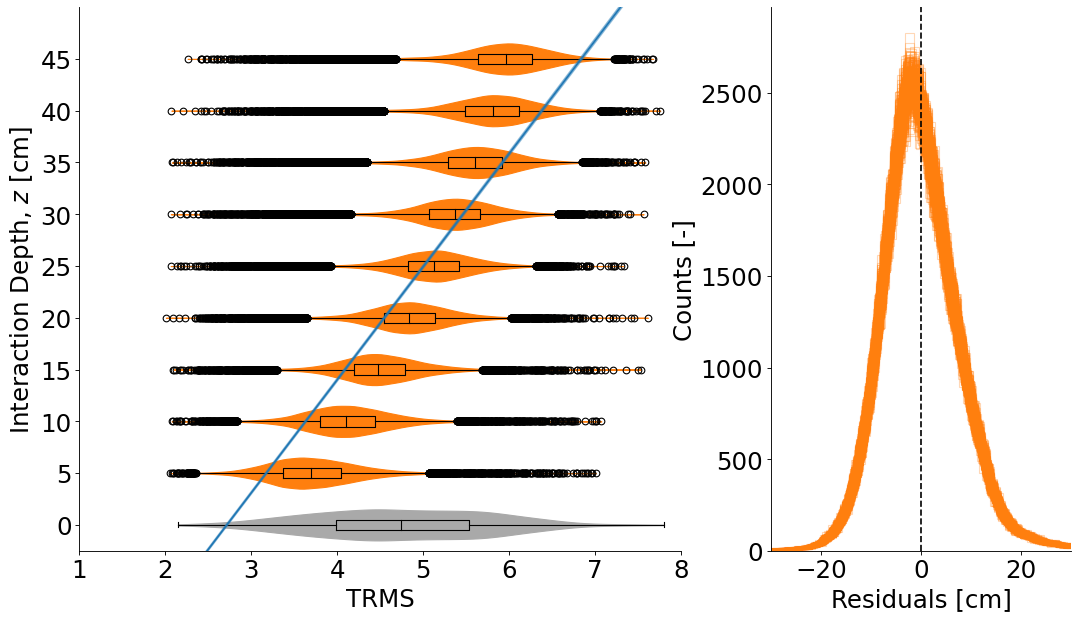

In [ ]:
## Simple linear regression

feature = 'TRMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 1 #@param {type:"number"}
xmax = 8 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.596+/-0.014
RMSE =  7.85+/-0.13
MAE =  5.97+/-0.09
Intercept:  -5.8+/-0.5
1 orded coef. =  0.74+/-0.21
2 orded coef. =  1.048+/-0.022


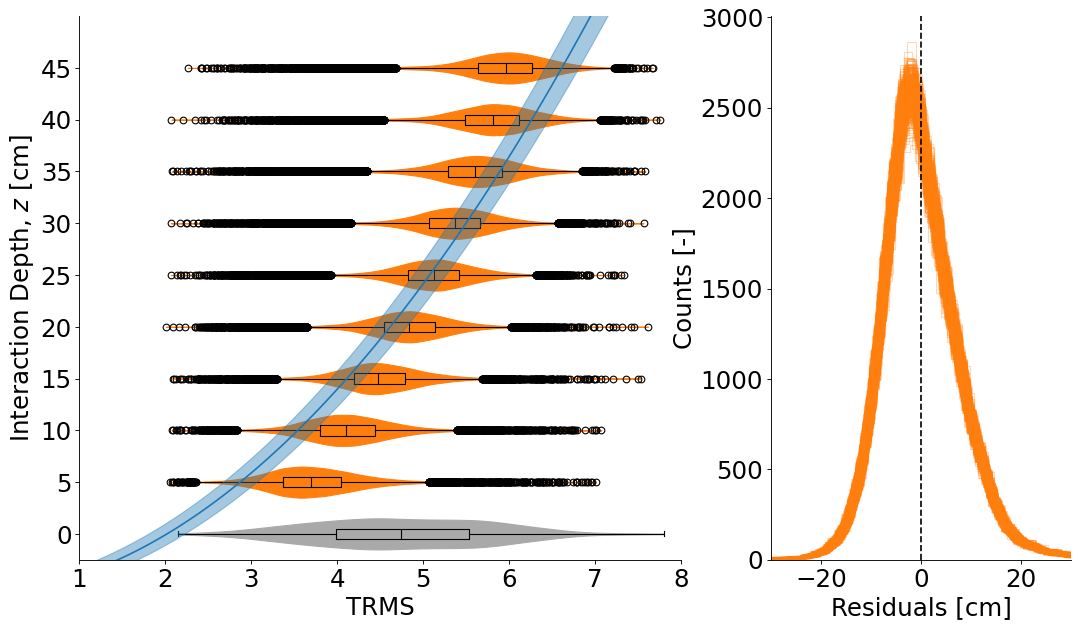

In [ ]:
## Simple linear regression

feature = 'TRMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 1 #@param {type:"number"}
xmax = 8 #@param {type:"number"}
polinomial = 2 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### $\sigma_T$

In [ ]:
#@markdown Linear models with TSigma are only significant up to order 2.
probe_p(roi, 'TSigma', 2)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                 1.633e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:15:52   Log-Likelihood:            -8.8130e+05
No. Observations:              250677   AIC:                         1.763e+06
Df Residuals:                  250674   BIC:                         1.763e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7605      0.382    -15.093      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.560+/-0.015
RMSE =  8.19+/-0.14
MAE =  6.25+/-0.09
Intercept:  -26.89+/-0.11
1 orded coef. =  10.362+/-0.022


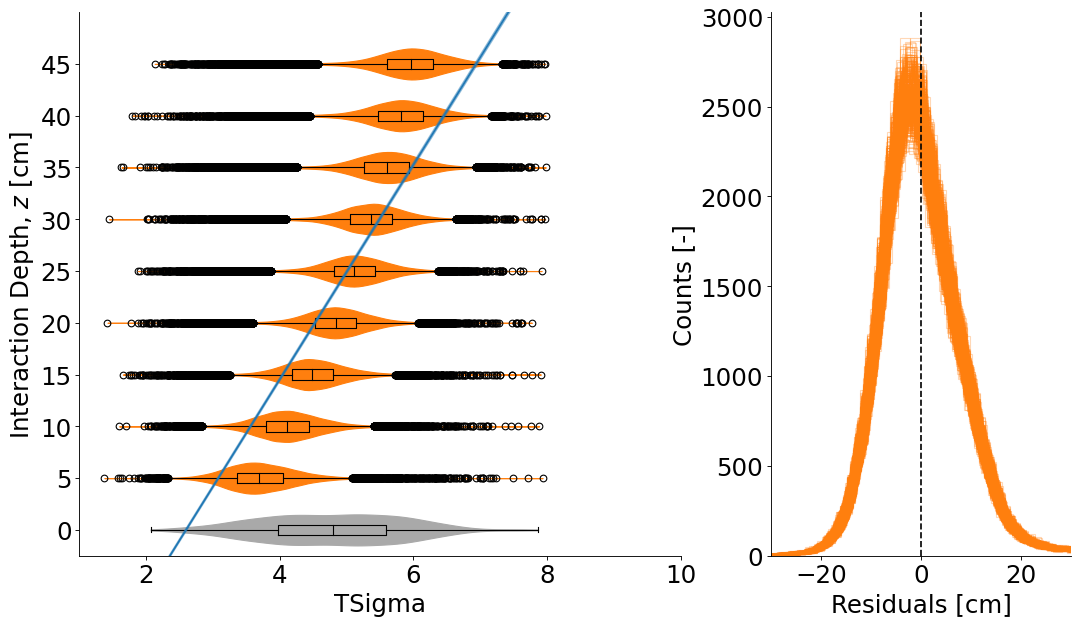

In [ ]:
## Simple linear regression

feature = 'TSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 1 #@param {type:"number"}
xmax = 10 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.566+/-0.015
RMSE =  8.14+/-0.14
MAE =  6.23+/-0.09
Intercept:  -5.8+/-0.6
1 orded coef. =  1.36+/-0.23
2 orded coef. =  0.927+/-0.023


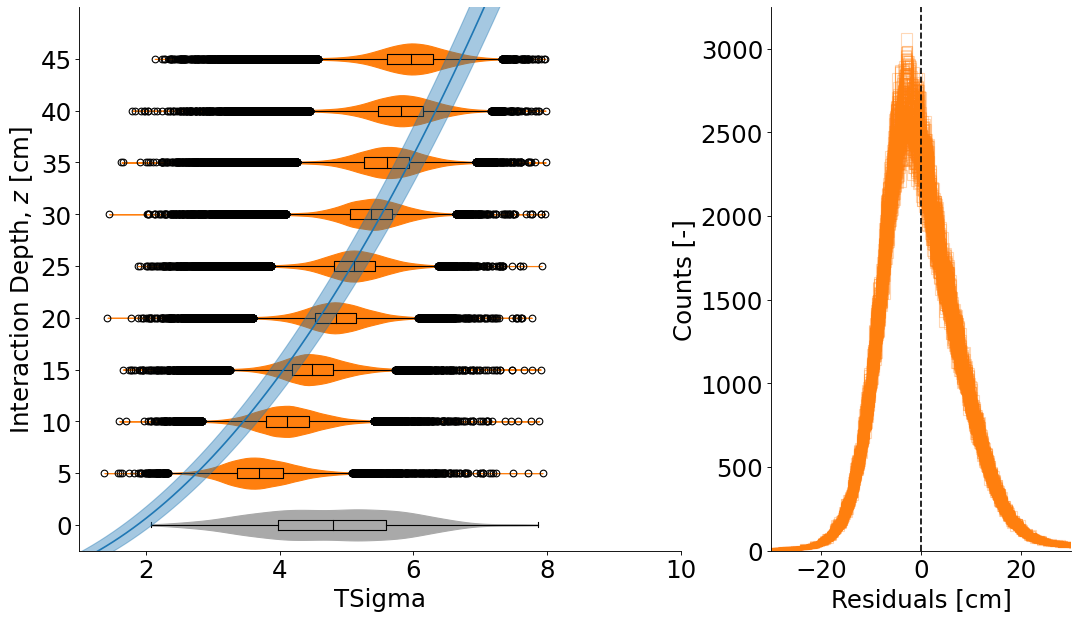

In [ ]:
## Simple linear regression

feature = 'TSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 1 #@param {type:"number"}
xmax = 10 #@param {type:"number"}
polinomial = 2 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### LRMS

In [ ]:
#@markdown Linear models with LRMS are only significant up to order 1.
probe_p(roi, 'LRMS', 1)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                 2.634e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:31:30   Log-Likelihood:            -8.9584e+05
No. Observations:              250677   AIC:                         1.792e+06
Df Residuals:                  250675   BIC:                         1.792e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.2290      0.112   -288.194      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.512+/-0.013
RMSE =  8.63+/-0.12
MAE =  6.79+/-0.09
Intercept:  -32.23+/-0.10
1 orded coef. =  9.669+/-0.018


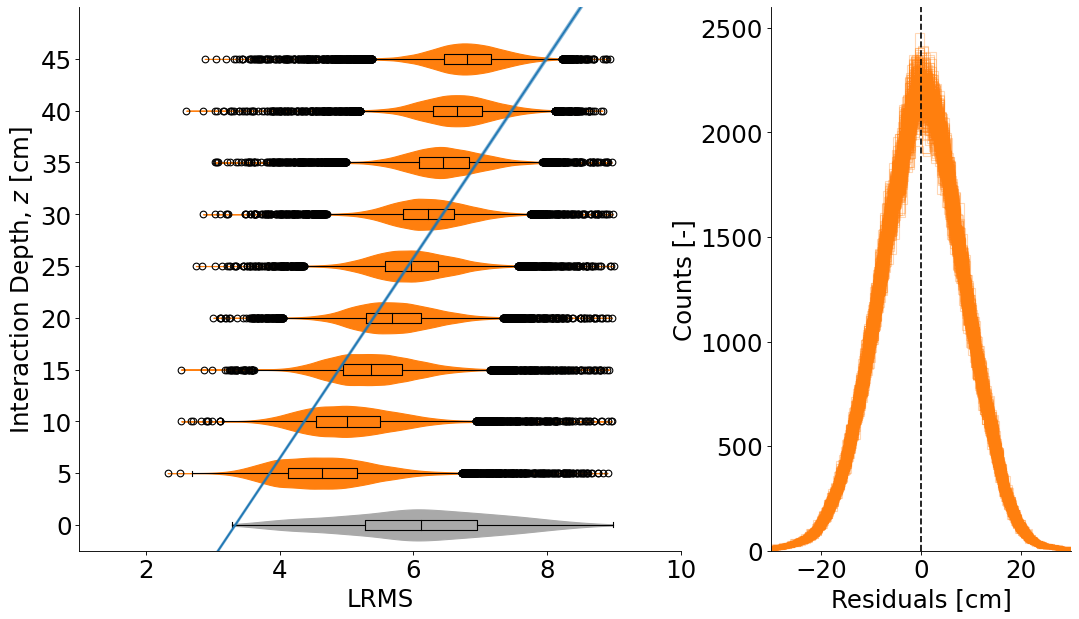

In [ ]:
## Simple linear regression

feature = 'LRMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 1 #@param {type:"number"}
xmax = 10 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### $\sigma_L$

In [ ]:
#@markdown Linear models with LSigma are only significant up to order 1.
probe_p(roi, 'LSigma', 1)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                 2.616e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:35:49   Log-Likelihood:            -8.9628e+05
No. Observations:              250677   AIC:                         1.793e+06
Df Residuals:                  250675   BIC:                         1.793e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.8567      0.100   -258.773      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.511+/-0.013
RMSE =  8.64+/-0.12
MAE =  6.80+/-0.09
Intercept:  -25.86+/-0.09
1 orded coef. =  8.158+/-0.015


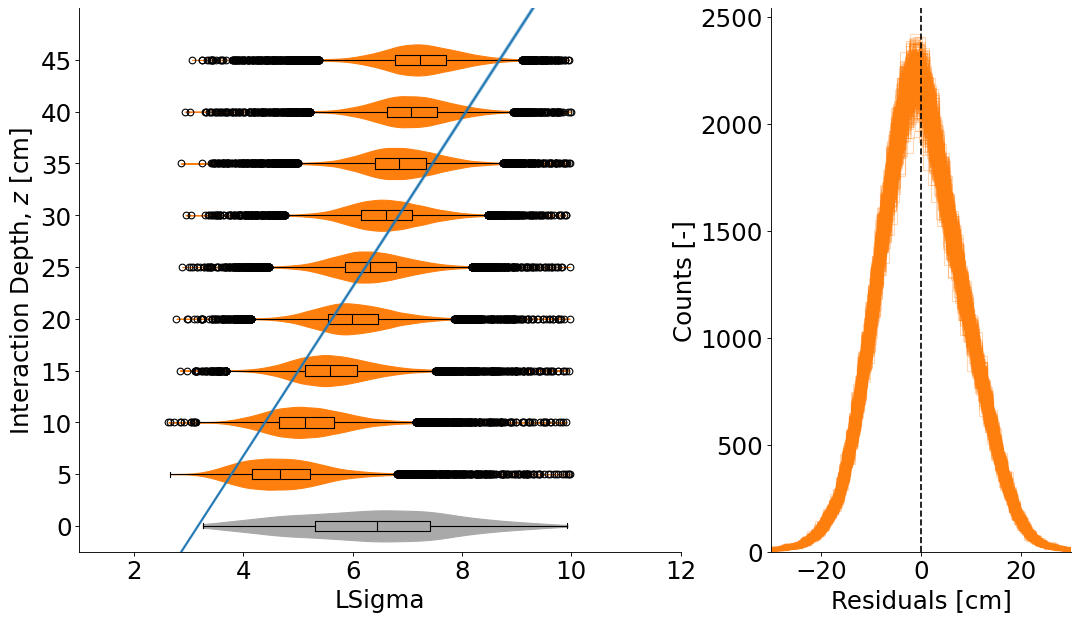

In [ ]:
## Simple linear regression

feature = 'LSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 1 #@param {type:"number"}
xmax = 12 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### Long_RMS

In [ ]:
#@markdown Linear models with Long_RMS are only significant up to order 1.
probe_p(roi, 'Long_RMS', 1)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                 2.603e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:40:37   Log-Likelihood:            -8.9659e+05
No. Observations:              250677   AIC:                         1.793e+06
Df Residuals:                  250675   BIC:                         1.793e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.0843      0.112   -285.961      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.509+/-0.013
RMSE =  8.65+/-0.12
MAE =  6.81+/-0.09
Intercept:  -32.08+/-0.10
1 orded coef. =  9.623+/-0.018


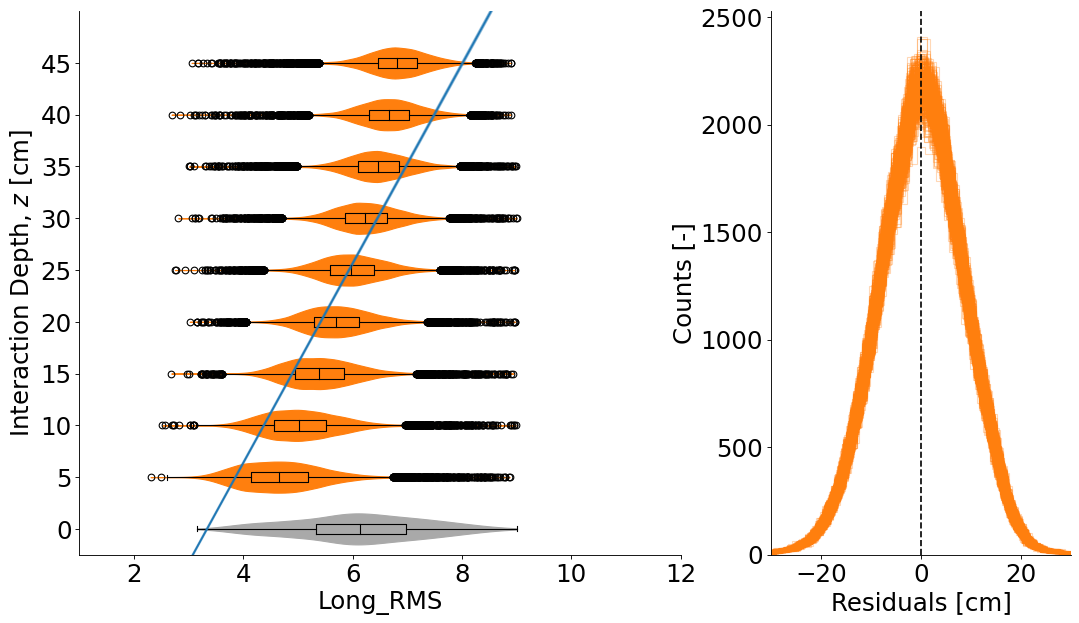

In [ ]:
## Simple linear regression

feature = 'Long_RMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 1 #@param {type:"number"}
xmax = 12 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### $\sigma_L \times $ TRMS

In [ ]:
roi['LSigma*TRMS']=roi['LSigma']*roi['TRMS']

#@markdown Linear models with Long_RMS are only significant up to order 1.
probe_p(roi, 'LSigma*TRMS', 1)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                 4.591e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:46:10   Log-Likelihood:            -8.5540e+05
No. Observations:              250677   AIC:                         1.711e+06
Df Residuals:                  250675   BIC:                         1.711e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5175      0.049   -152.041      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.647+/-0.012
RMSE =  7.34+/-0.13
MAE =  5.52+/-0.08
Intercept:  -7.52+/-0.05
1 orded coef. =  1.0233+/-0.0015


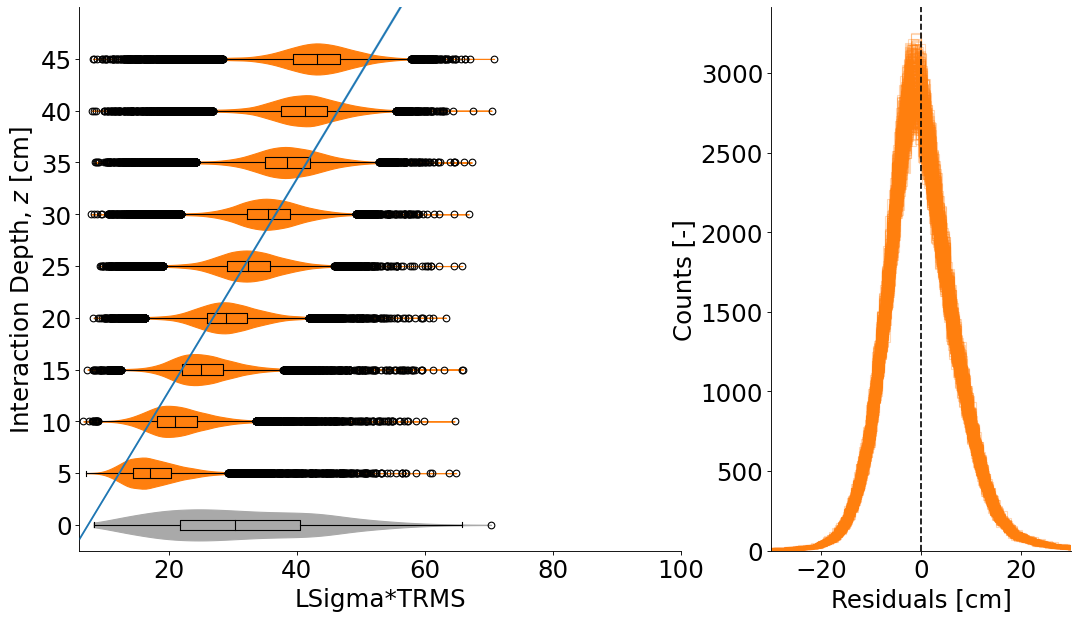

In [ ]:
## Simple linear regression

feature = 'LSigma*TRMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 6 #@param {type:"number"}
xmax = 100 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### LRMS $\times$ TRMS

In [ ]:
roi['LRMS*TRMS']=roi['LRMS']*roi['TRMS']

#@markdown Linear models with LRMS are only significant up to order 1.
probe_p(roi, 'LRMS*TRMS', 1)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                 4.549e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:52:51   Log-Likelihood:            -8.5615e+05
No. Observations:              250677   AIC:                         1.712e+06
Df Residuals:                  250675   BIC:                         1.712e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9989      0.052   -173.834      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.645+/-0.013
RMSE =  7.36+/-0.13
MAE =  5.54+/-0.08
Intercept:  -9.00+/-0.05
1 orded coef. =  1.1284+/-0.0017


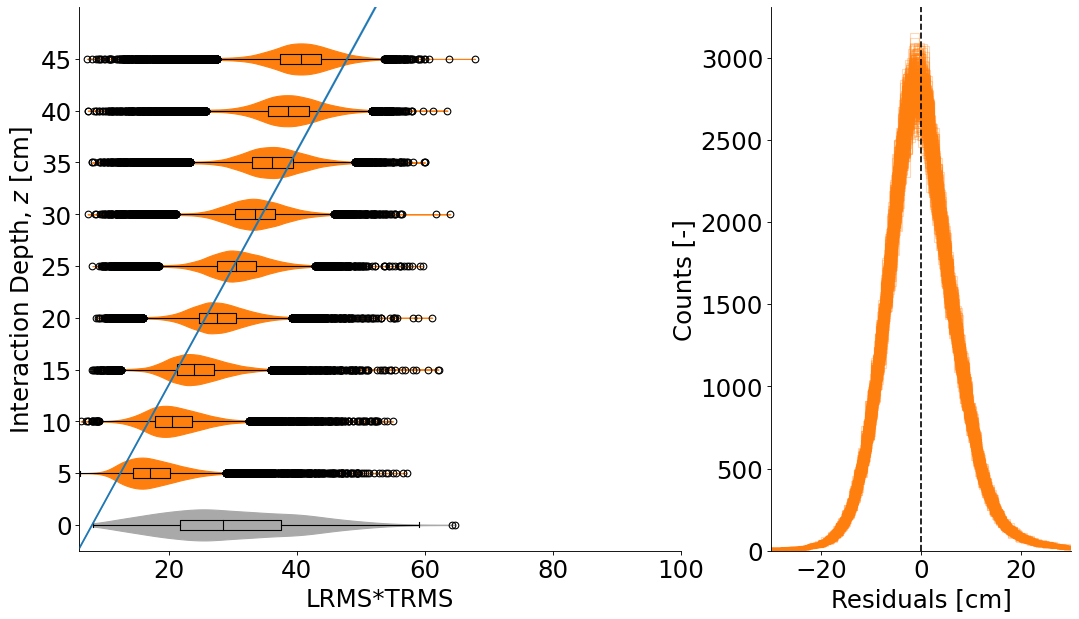

In [ ]:
## Simple linear regression

feature = 'LRMS*TRMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 6 #@param {type:"number"}
xmax = 100 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### Long_RMS $\times$ TRMS

In [ ]:
roi['Long_RMS*TRMS']=roi['Long_RMS']*roi['TRMS']

#@markdown Linear models with Long_RMS are only significant up to order 1.
probe_p(roi, 'Long_RMS*TRMS', 1)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                 4.531e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:57:50   Log-Likelihood:            -8.5646e+05
No. Observations:              250677   AIC:                         1.713e+06
Df Residuals:                  250675   BIC:                         1.713e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9987      0.052   -173.511      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.644+/-0.013
RMSE =  7.37+/-0.13
MAE =  5.55+/-0.08
Intercept:  -9.00+/-0.05
1 orded coef. =  1.1260+/-0.0017


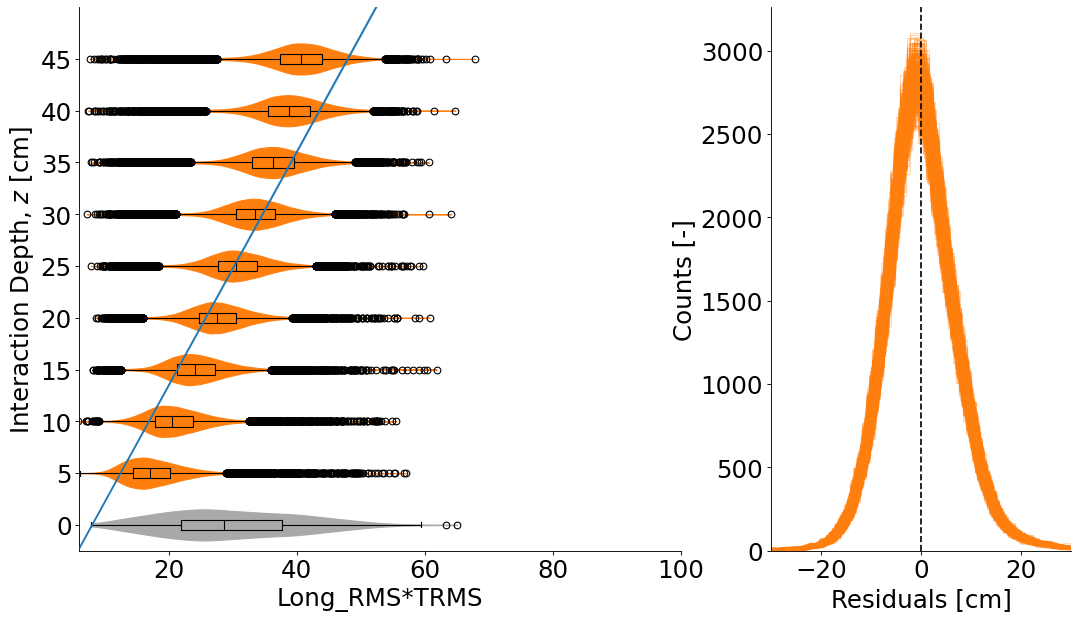

In [ ]:
## Simple linear regression

feature = 'Long_RMS*TRMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 6 #@param {type:"number"}
xmax = 100 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### $\sigma_L \times \sigma_T$

In [ ]:
roi['TSigma*LSigma']=roi['TSigma']*roi['LSigma']

#@markdown Linear models with TSigma*LSigma are only significant up to order 1.
probe_p(roi, 'TSigma*LSigma', 1)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                 4.426e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:02:57   Log-Likelihood:            -8.5836e+05
No. Observations:              250677   AIC:                         1.717e+06
Df Residuals:                  250675   BIC:                         1.717e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.0846      0.050   -142.523      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.638+/-0.013
RMSE =  7.43+/-0.13
MAE =  5.60+/-0.08
Intercept:  -7.08+/-0.05
1 orded coef. =  1.0102+/-0.0016


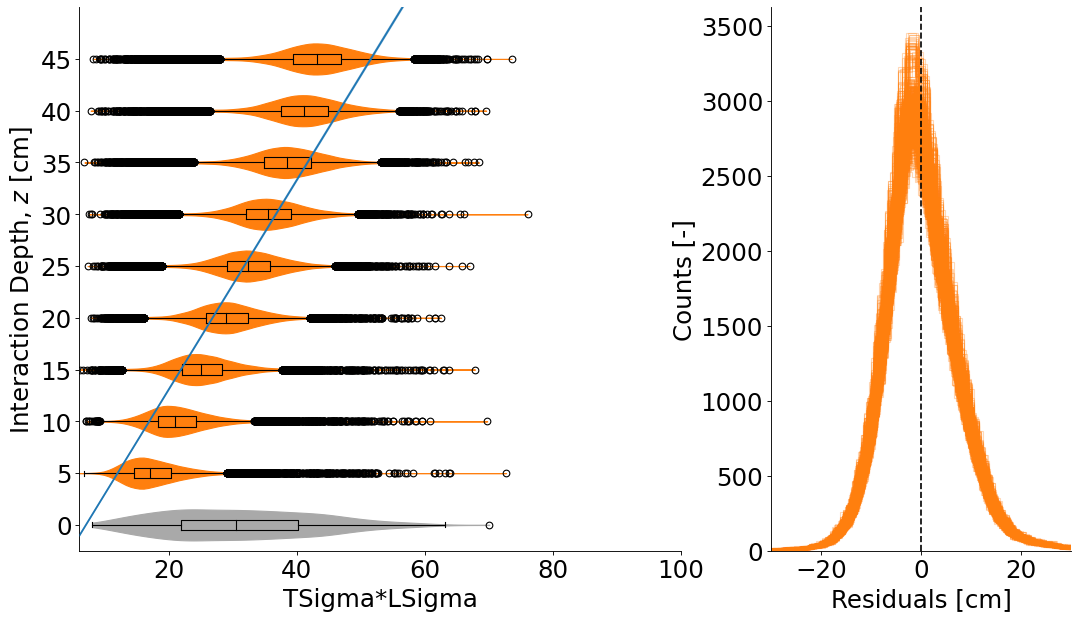

In [ ]:
## Simple linear regression

feature = 'TSigma*LSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 6 #@param {type:"number"}
xmax = 100 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### $\sigma_T \times$ LRMS

In [ ]:
roi['TSigma*LRMS']=roi['TSigma']*roi['LRMS']

#@markdown Linear models with TSigma*LRMS are only significant up to order 1.
probe_p(roi, 'TSigma*LRMS', 1)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                 4.384e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:06:46   Log-Likelihood:            -8.5912e+05
No. Observations:              250677   AIC:                         1.718e+06
Df Residuals:                  250675   BIC:                         1.718e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5351      0.052   -164.032      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.636+/-0.013
RMSE =  7.45+/-0.14
MAE =  5.61+/-0.08
Intercept:  -8.54+/-0.06
1 orded coef. =  1.1136+/-0.0018


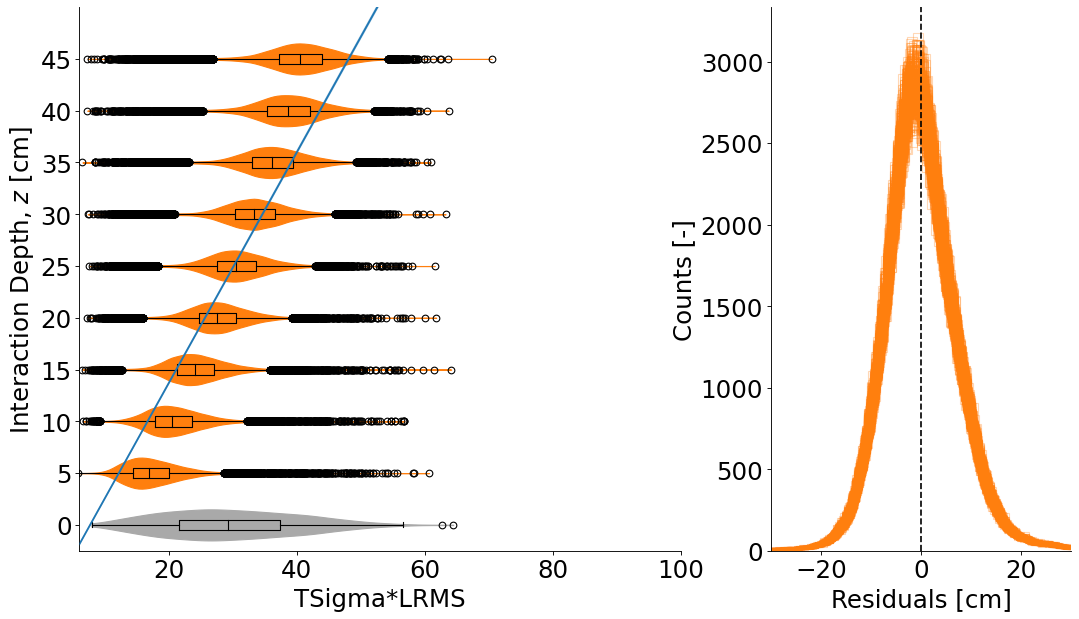

In [ ]:
## Simple linear regression

feature = 'TSigma*LRMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 6 #@param {type:"number"}
xmax = 100 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### $\sigma_T \times$ Long_RMS

In [ ]:
roi['TSigma*Long_RMS']=roi['TSigma']*roi['Long_RMS']

#@markdown Linear models with TSigma*LRMS are only significant up to order 1.
probe_p(roi, 'TSigma*Long_RMS', 1)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                 4.366e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:11:28   Log-Likelihood:            -8.5943e+05
No. Observations:              250677   AIC:                         1.719e+06
Df Residuals:                  250675   BIC:                         1.719e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5319      0.052   -163.668      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.635+/-0.013
RMSE =  7.46+/-0.13
MAE =  5.62+/-0.08
Intercept:  -8.53+/-0.06
1 orded coef. =  1.1112+/-0.0018


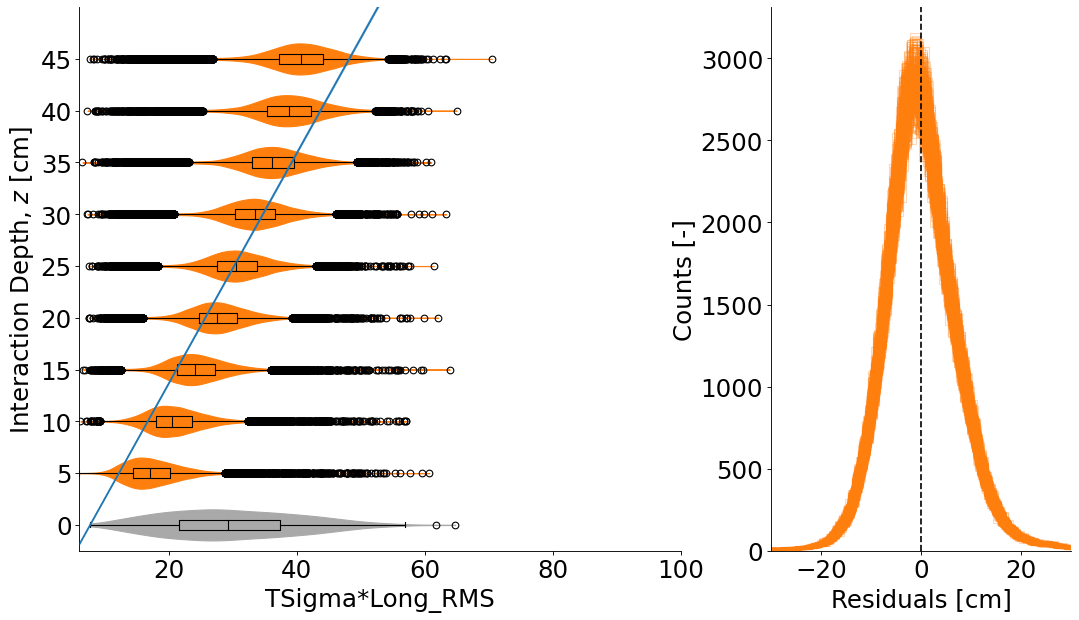

In [ ]:
## Simple linear regression

feature = 'TSigma*Long_RMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 6 #@param {type:"number"}
xmax = 100 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

### TRMS/RMS

In [ ]:
roi['TRMS/RMS']=roi['TRMS']/roi['RMS']

#@markdown Linear models with TRMS*RMS are only significant up to order 3.
probe_p(roi, 'TRMS/RMS', 3)

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                 1.395e+05
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:15:34   Log-Likelihood:            -8.6280e+05
No. Observations:              250677   AIC:                         1.726e+06
Df Residuals:                  250673   BIC:                         1.726e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8395      0.471     31.509      0.0

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.599+/-0.013
RMSE =  7.83+/-0.13
MAE =  6.00+/-0.09
Intercept:  -12.15+/-0.06
1 orded coef. =  94.49+/-0.17


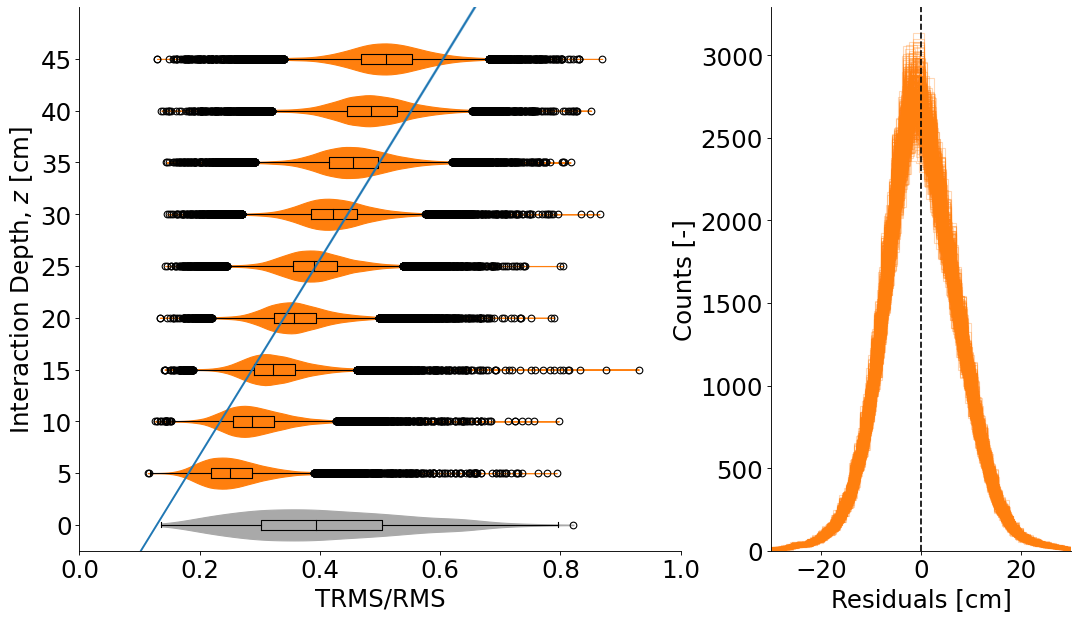

In [ ]:
## Simple linear regression

feature = 'TRMS/RMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 0 #@param {type:"number"}
xmax = 1 #@param {type:"number"}
polinomial = 1 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
r2 =  0.611+/-0.013
RMSE =  7.70+/-0.13
MAE =  5.91+/-0.08
Intercept:  -27.71+/-0.23
1 orded coef. =  177.7+/-1.2
2 orded coef. =  -104.1+/-1.5


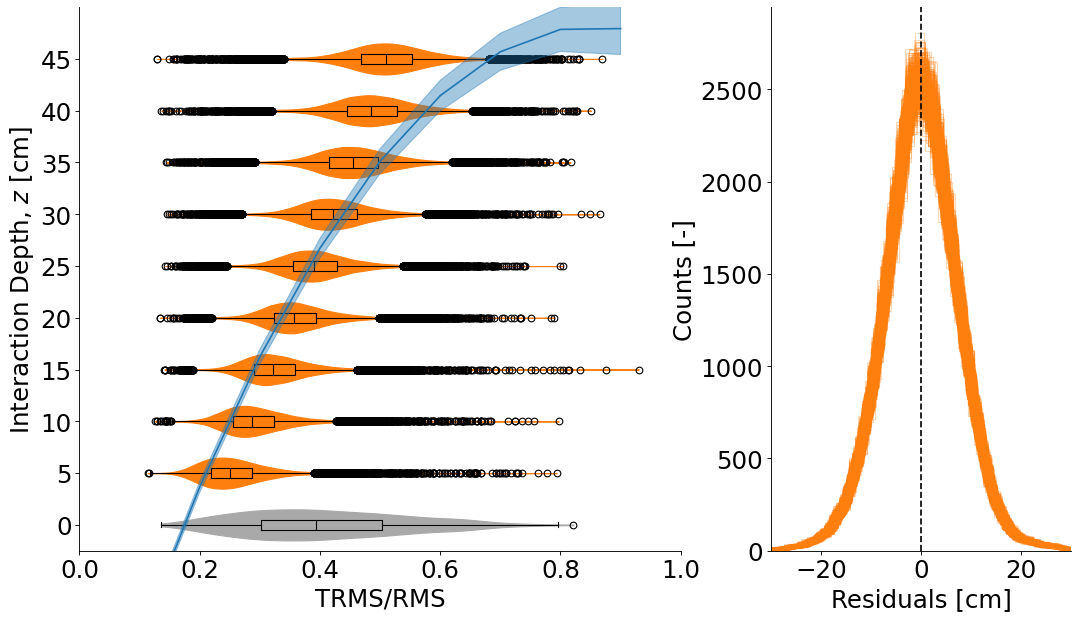

In [ ]:
## Simple linear regression

feature = 'TRMS/RMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 0 #@param {type:"number"}
xmax = 1 #@param {type:"number"}
polinomial = 2 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

In [ ]:
## Simple linear regression

feature = 'TRMS/RMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin = 0 #@param {type:"number"}
xmax = 1 #@param {type:"number"}
polinomial = 3 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax, pol=polinomial)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

# Below are testing stuff

In [ ]:
## 

In [ ]:
def severalfeat(roi, features, xmin, xmax, pol):
  # Linear fit
  Y = roi['z[cm]'].loc[roi['z[cm]']>0]
  X = roi[features].loc[roi['z[cm]']>0]

  results = np.ones((4+pol,500))*np.nan
  i = 0
  rkf = RepeatedKFold(n_splits=10, n_repeats=50, random_state=0)
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    polynomial_features= PolynomialFeatures(degree=pol)
    X_train = polynomial_features.fit_transform(X_train)
    X_test = polynomial_features.fit_transform(X_test)
    X_test = sm.add_constant(X_test)

    clf = LinearRegression().fit(X_train, y_train)
    preds = clf.predict(X_test)

    #Residual plot
    residuals = y_test-preds
    #ax[1].hist(residuals, bins=50, color='tab:orange', alpha=0.3, histtype='step')

    results[0,i] = r2_score(y_test, preds) # r2
    results[1,i] = np.sqrt(mean_squared_error(y_test, preds)) # RMSE
    results[2,i] = mean_absolute_error(y_test, preds) # MAE
    results[3,i]=clf.intercept_ # intercept
    for coefficient in range(0,pol):
      results[4+coefficient, i] = clf.coef_[coefficient+1]

    i=i+1

  print('MODEL SUMMARY:')
  print('r2 = ', ufloat(np.mean(results[0,:]), 3*np.std(results[0,:])))
  print('RMSE = ', ufloat(np.mean(results[1,:]), 3*np.std(results[1,:])))
  print('MAE = ', ufloat(np.mean(results[2,:]), 3*np.std(results[2,:])))
  intercept = np.mean(results[3,:])
  dintercept = 3*np.std(results[3,:])
  print('Intercept: ', ufloat(np.mean(results[3,:]), 3*np.std(results[3,:])))
  coef = []
  dcoef = []
  for coefficient in range(0,pol):
    coef.append(np.mean(results[4+coefficient,:]))
    dcoef.append(3*np.std(results[4+coefficient,:]))
    print(coefficient+1,'orded coef. = ', ufloat(np.mean(results[4+coefficient,:]), 3*np.std(results[4+coefficient,:])))


In [ ]:
severalfeat(roi, ['TSigma', 'LSigma'], xmin, xmax, 1)


MODEL SUMMARY:
r2 =  0.638+/-0.013
RMSE =  7.43+/-0.13
MAE =  5.60+/-0.08
Intercept:  -35.95+/-0.10
1 orded coef. =  6.759+/-0.030


In [ ]:
Y = roi['z[cm]'].loc[roi['z[cm]']>0]
X = roi[['yMean',
       'TChi2', 'TSigma', 'TFWHM', 'TMean',
       'RMS', 'LChi2','LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM',
       'eta', 'TSigma*LSigma', 'TSigma/RMS', 'LSigma*TFWHM']].loc[roi['z[cm]']>0]
polynomial_features= PolynomialFeatures(degree=1)
X = polynomial_features.fit_transform(X)
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  z[cm]   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                 3.483e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:41:16   Log-Likelihood:            -8.3915e+05
No. Observations:              250677   AIC:                         1.678e+06
Df Residuals:                  250660   BIC:                         1.679e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.9717      0.827     26.561      0.0

In [ ]:
severalfeat(roi, ['yMean',
       'TChi2', 'TSigma', 'TFWHM', 'TMean',
       'RMS', 'LChi2','LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM',
       'eta', 'TSigma*LSigma', 'TSigma/RMS', 'LSigma*TFWHM'], xmin, xmax, 1)


MODEL SUMMARY:
r2 =  0.690+/-0.012
RMSE =  6.88+/-0.13
MAE =  5.17+/-0.08
Intercept:  22.0+/-1.2
1 orded coef. =  -0.00113+/-0.00009


## Wrapper Methods

In [ ]:
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
p = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(f_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
  p = np.append(p, sel.pvalues_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'F-Score': scores,
        'P-value': p}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t f-score :', ufloat(df['F-Score'].loc[df['Feature']==feature].mean(), df['F-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['F-Score'].loc[df['Feature']==feature].count(),
          '\n \t p-value :', ufloat(df['P-value'].loc[df['Feature']==feature].mean(), df['P-value'].loc[df['Feature']==feature].std()))
  display('-'*100)

KeyboardInterrupt: ignored

In [ ]:
##@title Forward Selection using Linear Regression
##@markdown I selected up to 5 features.
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=5)
  sfs.fit(X_train, y_train)
  selected = np.append(selected, sfs.get_feature_names_out())
  #for feature in [x for x in X_train.columns if x in X_train.columns[sfs.get_support()]]:
    #selected.append(feature)
for feature in set(selected):
  print(feature, selected.count(feature))
display('-'*100)

['TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel'
 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma'
 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma'
 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2'
 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta'
 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta']


'----------------------------------------------------------------------------------------------------'

# Z-estimate


## Wrapper methods

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

fit_data = roi.loc[roi['z[cm]']>0] 
x = fit_data.drop(['z[cm]'], axis=1)
y = fit_data['z[cm]']

RFE_regressor = LinearRegression()#SVR(kernel='linear')#

for nfeat in range(1,6):
  print('For '+str(nfeat)+' features:')
  rfe = RFE(RFE_regressor, n_features_to_select=nfeat, step=1)
  rfe = rfe.fit(x,y)
  print(x.columns[rfe.support_])
  print(rfe.score(x,y))

For 1 features:
Index(['TSigma'], dtype='object')
0.5601060664685693
For 2 features:
Index(['TSigma', 'LSigma'], dtype='object')
0.6384074740235497
For 3 features:
Index(['TSigma', 'LSigma', 'eta'], dtype='object')
0.6384241291958714
For 4 features:
Index(['TSigma', 'RMS', 'LSigma', 'eta'], dtype='object')
0.6573803859312641
For 5 features:
Index(['Slim', 'TSigma', 'RMS', 'LSigma', 'eta'], dtype='object')
0.6573847455068815


"\nRFE_regressor = LinearRegression()\nrfe = RFE(RFE_regressor, n_features_to_select=5, step=1)\n\nrfe = rfe.fit(x,y)\n\nfor index in range(0, len(rfe.ranking_)):\n  print(x.columns[index], str('\t'), rfe.ranking_[index])\n  "